In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
from winkie import ml
from winkie import dlc_importer
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
import re


# TODO: this is implicitly coupled to the model
features = [('head', 'x'), ('head', 'y'), ('tail', 'x'), ('left_neck', 'y'), ('right_neck', 'y')]

def build_timeseries(df, features, timeslice_length):
    "Split the data in `df` into timeseries segments of length `timeslice_length` containing given `features`."
    
    segments = []
    for i in range(0, len(df) - timeslice_length + 1, timeslice_length):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        segments.append(s)

    return np.asarray(segments).reshape(-1, timeslice_length, len(features))

def apply_model_and_check_performance(model_name, result_file_name, expted_label_file_name, label_mapping):
    p = re.compile(r'(^[A-Za-z_]*) *= *(?:slice)? ?\((\d*), ?(\d*)\)')
    behaviours = []
    with open(expted_label_file_name) as f:
      for x in f:
        m = p.match(x)
        frames = int(m.group(3)) - int(m.group(2))
        b = m.group(1)
        behaviours += frames * [b]
    expected = pd.Series(behaviours)
    
    model = keras.models.load_model(model_name)
    
    imp = dlc_importer.DLCImporter()
    df = imp.import_hdf(result_file_name)
    df['expected'] = expected

    
    timeslice = 7
    segments = build_timeseries(df, features, timeslice)

    predictions = model.predict(segments)

    classes = pd.Series(np.argmax(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)
    confidence = pd.Series(np.max(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)

    df['class'] = classes
    df['class'] = df['class'].replace(np.NaN, 1.0)
    df['b'] = df.apply(lambda row: label_mapping[int(row['class'])], axis=1)

    df['confidence'] = confidence
    
    df_anomalies = df[(df['class'] != 1.0) & (df['class'] != -1.0)]
    df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum())

    recall = []

    for k, v in df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum()):
        recall.append([
            v['b'].head(1).values[0], 
            v['expected'].unique(), 
            v['expected'].head(1).values[0],
            datetime.timedelta(seconds=v.head(1).index.values[0] / 119.88),
            len(v), 
            v.head(1).index.values[0],
            v.tail(1).index.values[0]])

    df_performance = pd.DataFrame(recall, columns=['detected', 'expected', 'confidence', 'time', 'length', 'start', 'end'])
    
    return df, df_performance, predictions

<AxesSubplot:>

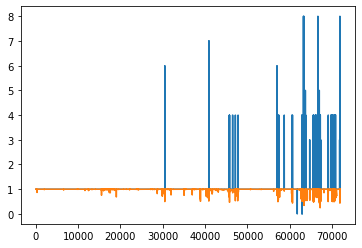

In [ ]:
# TODO: save and load from a file after training
label_mapping = ['back_preening', 'base', 'body_pump', 'feather_clapping', 'front_preening', 'head_shake', 'scratch_with_feet', 'standing_shaking', 'tail_shake']

df, df_p, pred = apply_model_and_check_performance("model_7s-1000e-256b-0015L-preening-nosampling", '233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5', "completely_labelled_233monhabday1.txt", label_mapping)
df['class'].plot()
df['confidence'].plot()

In [ ]:
df

label_mapping = [
    'back_preening', 
    'base', 
    'body_pump', 
    'feather_clapping', 
    'front_preening', 
    'head_shake', 
    'scratch_with_feet', 
    'standing_shaking', 
    'tail_shake']

df['expected'].unique()

expected_class_lookup = {
    'eating': 1.0,
    'standing': 1.0,
    'hp': 5.0,
    'walking': 1.0,
    'fp': 4.0,
    'sf': 6.0,
    'bp': 2.0,
    'eating_flor': 1.0,
    np.NAN: 1.0
}

df['expected_class'] = df.apply(lambda row: expected_class_lookup[row['expected'][0]], axis=1)

Difference accuracy calculcations.

In [ ]:
def calc_accuracy(df):
    ytrue = df['expected_class']
    ypred = df['class']

    metric = tf.keras.metrics.Accuracy()
    metric.update_state(ytrue, ypred)
    print(metric.result().numpy())

def calc_cat_accuracy(df, pred):
    ytrue = encode_true(df)
    metric = tf.keras.metrics.CategoricalAccuracy()
    metric.update_state(ytrue[:-1], np.repeat(a = pred, repeats=7, axis=0))
    print(metric.result().numpy())

def calc_f1(df, pred):
    ytrue = encode_true(df)
    metric = tfa.metrics.F1Score(num_classes=len(ytrue[0]), threshold=None)
    metric.update_state(ytrue[:-1], np.repeat(a = pred, repeats=7, axis=0))
    print(metric.result().numpy())
    
def encode_true(df):
    ytrue = []
    for i, v in df['expected_class'].items():
        exp = [0] * 9
        exp[int(v)] = 1
        ytrue.append(exp)
    return ytrue

In [ ]:
calc_accuracy(df)
calc_cat_accuracy(df, pred)
calc_f1(df, pred)

0.98452574
0.98452556
[0.         0.99223423 0.1640625  0.         0.8037529  0.
 0.         0.         0.        ]


In [ ]:
# TODO: save and load from a file after training
label_mapping = ['back_preening', 'feather_clapping', 'front_preening', 'head_shake', 'scratch_with_feet', 'standing_shaking', 'tail_shake']

df_category, _ = apply_model_and_check_performance("model_7s-1000e-256b-0015L-preening-nosampling-nobase", '233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5', "completely_labelled_233monhabday1.txt", label_mapping)

In [ ]:
for index, row in df_p.iterrows():
    x = df_category.iloc[row['start']:row['end']]
    display(x)

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
30485      732.080811  268.046417   0.999999  861.110657  324.512207   
30486      727.263306  268.427979   1.000000  861.240356  324.163422   
30487      723.008301  267.432892   1.000000  860.393311  325.016968   
30488      719.310669  268.387238   1.000000  861.126587  324.205536   
30489      716.845459  269.863251   1.000000  861.155029  324.684601   
30490      713.367798  269.429138   1.000000  861.347717  324.991333   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
30485       0.985165  710.596069  334.869049   0.999999  780.918823  ...   
30486       0.977675  709.757996  335.291199   1.000000  773.085266  ...   
30487       0.976041  709.046936  334.944366   1.000000  769.869873  ...   
30488       0.980432  708.345459  335.743134   0.999997  765.270569  ...   
30489       0.991413  707.848694  335.543884   0.999998  762.020386  ...   
30490       0.989165  707.424255  335.329956   0.999997  761.380066  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
30485      755.165588  436.798584   0.999988  761.931702  593.644104   
30486      755.796997  437.482361   0.999993  762.786499  593.690369   
30487      756.382385  436.961426   0.999992  764.205994  593.915771   
30488      755.221924  435.694122   0.999990  764.603638  593.454712   
30489      755.539429  434.354889   0.999987  764.793030  594.444031   
30490      756.767212  436.543823   0.999984  767.138184  594.319702   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
30485       0.999999    eating   3.0  head_shake   0.598263  
30486       0.999999    eating   3.0  head_shake   0.598263  
30487       1.000000    eating   3.0  head_shake   0.598263  
30488       0.999999    eating   3.0  head_shake   0.598263  
30489       0.999998    eating   3.0  head_shake   0.598263  
30490       0.999998    eating   3.0  head_shake   0.598263  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
40880      529.792969  266.355591   0.999999  529.383362  244.930466   
40881      534.075684  265.539581   0.999999  533.446899  242.554550   
40882      535.885315  263.708679   0.999999  537.601318  240.621979   
40883      537.442322  262.706970   1.000000  540.569763  240.288666   
40884      538.544189  260.697235   1.000000  541.993408  238.769653   
40885      539.197266  259.677643   1.000000  544.423218  237.785080   
40886      539.716431  258.916046   1.000000  545.229187  236.826218   
40887      539.935547  259.423523   1.000000  544.867554  237.001266   
40888      540.966370  259.881653   0.999999  544.761169  237.191727   
40889      540.890625  259.674622   1.000000  545.264771  236.531860   
40890      540.781555  259.731049   1.000000  545.717102  237.167969   
40891      540.858215  259.792267   1.000000  546.418213  236.884430   
40892      541.004700  259.010132   1.000000  546.356506  235.871399   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
40880       0.998936  497.698517  376.801666   0.999983  558.556335  ...   
40881       0.999373  498.550812  373.694153   0.999992  563.021851  ...   
40882       0.998496  499.836884  371.406189   0.999941  565.817200  ...   
40883       0.999382  499.899780  369.732513   0.999995  566.330322  ...   
40884       0.999096  499.353210  367.732910   0.999982  567.923340  ...   
40885       0.999060  501.044708  366.371124   0.999948  569.287109  ...   
40886       0.998395  501.436584  365.651489   0.999946  570.944946  ...   
40887       0.998164  502.385345  363.316864   0.999875  572.356140  ...   
40888       0.998066  501.807434  361.721191   0.999994  573.025940  ...   
40889       0.998653  502.544983  359.557831   0.999987  573.333984  ...   
40890       0.996061  503.029419  356.375977   0.999988  573.583618  ...   
40891       0.997575  503.405670  355.425476   0.999991  575.064880  ...   
40892       0.998197  505.114685  354.623749   0.999997  576.893311  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
40880      593.949097  434.752411   0.999988  697.301453  561.648804   
40881      593.873962  436.301666   0.999994  696.893066  562.104431   
40882      593.304016  434.595123   0.999980  695.538879  561.445190   
40883      593.745972  434.115234   0.999991  695.229980  561.672180   
40884      592.240356  433.018890   0.999987  693.433899  563.377319   
40885      592.923645  432.207947   0.999982  690.268982  563.890259   
40886      592.305908  430.603119   0.999984  688.718872  566.989990   
40887      592.446411  427.589966   0.999981  685.617981  566.659790   
40888      591.445618  429.604065   0.999975  685.024170  566.933228   
40889      589.680176  429.385803   0.999990  684.395691  568.541870   
40890      588.234070  427.607574   0.999995  681.139404  569.409790   
40891      587.796265  427.646820   0.999997  680.088806  569.977844   
40892      588.956848  427.055206   0.999994  678.234802  571.511414   

bodyparts            excpected class                 b confidence  
coords    likelihood                                               
40880       0.999997   walking   5.0  standing_shaking   0.999286  
40881       0.999998   walking   5.0  standing_shaking   0.999286  
40882       0.999999   walking   5.0  standing_shaking   0.999286  
40883       0.999997   walking   5.0  standing_shaking   0.999286  
40884       0.999999   walking   5.0  standing_shaking   0.999286  
40885       0.999999   walking   5.0  standing_shaking   0.999286  
40886       0.999996   walking   5.0  standing_shaking   0.999286  
40887       0.999992   walking   5.0  standing_shaking   0.995963  
40888       0.999

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
40929      549.155640  256.808014   0.999998  556.551514  233.979034   
40930      549.931335  258.511963   0.999994  563.286255  234.336746   
40931      554.859680  254.719482   0.999996  567.553223  235.559464   
40932      560.248840  255.464554   0.999998  577.168579  236.658142   
40933      566.110840  253.358765   0.999990  580.418640  235.430038   
40934      570.884888  250.274414   0.999983  584.813354  234.039795   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
40929       0.990026  521.458618  326.276672   0.999990  576.703552  ...   
40930       0.996245  521.775757  325.128571   0.999979  578.320984  ...   
40931       0.994948  521.617126  323.528656   0.999982  602.288086  ...   
40932       0.992388  520.055847  323.210449   0.999976  602.566711  ...   
40933       0.998968  519.877075  322.123077   0.999994  602.245850  ...   
40934       0.996982  520.207581  319.541931   0.999996  602.694641  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
40929      573.953552  418.771667   0.999998  602.894470  581.851929   
40930      572.842834  418.444000   0.999998  600.887695  582.439941   
40931      571.103455  415.950928   0.999990  598.553284  582.261597   
40932      570.770142  415.247314   0.999990  597.372253  580.285339   
40933      569.705444  413.136688   0.999987  593.661621  580.016296   
40934      569.311218  413.305969   0.999984  592.340820  580.725220   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
40929       0.999998   walking   2.0  front_preening   0.991879  
40930       0.999998   walking   2.0  front_preening   0.991879  
40931       0.999995   walking   2.0  front_preening   0.991879  
40932       0.999995   walking   2.0  front_preening   0.991879  
40933       0.999995   walking   2.0  front_preening   0.991879  
40934       0.999994   walking   2.0  front_preening   0.991879  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
40936      580.201050  248.146408   0.999988  595.749268  232.820404   
40937      583.862366  247.394333   0.999987  600.000122  231.256317   
40938      584.639099  246.009369   0.999998  602.151184  229.876404   
40939      586.755920  244.468781   0.999997  603.364014  228.156128   
40940      587.652344  244.203720   0.999996  604.736450  227.994339   
40941      587.965271  243.349854   0.999997  606.775024  227.891724   
40942      588.198364  243.422485   0.999995  607.564941  227.471298   
40943      588.298401  243.551605   0.999997  607.390381  227.684769   
40944      589.226929  242.482681   0.999998  607.275513  227.396027   
40945      589.510620  242.477844   0.999997  607.202759  227.289230   
40946      589.022583  242.767899   0.999997  608.063049  226.546722   
40947      589.269165  243.011398   0.999998  607.467224  227.009338   
40948      590.129822  242.955276   0.999998  607.073792  226.633591   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
40936       0.999981  519.315613  319.191376   0.999997  601.125854  ...   
40937       0.999904  519.192139  319.187988   0.999993  601.417908  ...   
40938       0.999888  519.209473  316.829590   0.999995  601.204895  ...   
40939       0.999947  518.066345  314.872223   0.999985  600.013184  ...   
40940       0.999871  518.805176  314.173584   0.999973  599.095459  ...   
40941       0.999828  517.879395  313.081970   0.999915  599.282104  ...   
40942       0.999729  518.446655  310.905029   0.999988  598.287415  ...   
40943       0.999497  517.908936  311.703339   0.999939  597.842712  ...   
40944       0.999020  517.915588  311.679810   0.999922  597.270386  ...   
40945       0.999407  517.456482  310.637421   0.999943  597.444214  ...   
40946       0.999654  517.024841  311.320496   0.999886  597.693848  ...   
40947       0.999536  517.245911  310.110870   0.999744  598.005920  ...   
40948       0.999824  517.081238  311.476501   0.999951  598.136597  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
40936      564.132324  413.096130   0.999996  589.584229  580.936096   
40937      563.296509  411.386353   0.999986  586.309814  580.956909   
40938      562.523926  411.239227   0.999993  583.137207  579.763489   
40939      560.852051  408.759277   0.999994  581.793701  579.440063   
40940      559.812500  408.972778   0.999988  577.240662  581.361877   
40941      559.751282  409.841614   0.999982  572.541077  582.901917   
40942      558.539001  409.889832   0.999987  569.121277  580.054810   
40943      557.320190  410.524750   0.999992  566.726624  579.026428   
40944      557.943604  408.103058   0.999988  564.114319  578.569336   
40945      555.924744  409.283295   0.999983  561.316467  578.455994   
40946      554.224426  410.137024   0.999981  559.230957  580.424072   
40947      552.475586  410.856201   0.999990  559.544067  580.308228   
40948      551.916992  411.285156   0.999994  556.792603  579.036743   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
40936       0.999999   walking   2.0  front_preening   0.872232  
40937       0.999998   walking   2.0  front_preening   0.872232  
40938       0.999995   walking   2.0  front_preening   0.872232  
40939       0.999983   walking   2.0  front_preening   0.872232  
40940       0.999985   walking   2.0  front_preening   0.872232  
40941       0.999994   walking   2.0  front_preening   0.872232  
40942       0.999995   walking   2.0  front_preening   0.872232  
40943       0.999991   walking   2.0  front_preening   0.819619  
40944       0.999993   walking   2.0 

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
45626      673.910583  215.448822   0.999913  668.180603  256.264893   
45627      674.150757  216.732574   0.999665  668.119812  257.550812   
45628      672.220764  225.493881   0.999668  668.028015  258.472870   
45629      671.846313  225.673523   0.999460  668.624390  258.976990   
45630      672.515381  225.914993   0.999616  667.705322  260.801575   
45631      673.701965  218.094055   0.999782  667.432617  261.038422   
45632      674.668579  214.697784   0.999783  667.637329  261.207184   
45633      674.905518  215.096649   0.999594  668.175293  260.864502   
45634      671.854553  228.215881   0.999650  667.952637  261.129028   
45635      672.421204  227.113663   0.999640  667.826172  261.965546   
45636      672.058594  227.366440   0.999734  668.162048  262.966522   
45637      672.903076  227.805008   0.999862  668.026978  263.356445   
45638      670.888000  226.221893   0.999110  670.563599  264.384277   
45639      672.986084  227.100464   0.999428  670.798035  265.350769   
45640      673.398315  226.756363   0.999827  668.377441  264.301605   
45641      672.602966  227.073013   0.999235  668.359253  264.932983   
45642      674.679688  217.251343   0.999363  668.864319  264.612091   
45643      673.545105  217.916306   0.999448  668.935425  264.657288   
45644      674.372742  227.202438   0.998599  669.757080  264.086578   
45645      675.272644  217.235641   0.999011  669.488770  264.157410   
45646      672.630005  228.150589   0.999100  669.748291  264.606750   
45647      673.477722  227.470444   0.999568  669.763123  265.805115   
45648      673.479919  226.664612   0.999125  669.813293  265.021973   
45649      673.877930  217.132523   0.999749  670.048828  264.636505   
45650      673.575562  226.165695   0.999440  670.616272  265.011261   
45651      673.669800  227.189957   0.999290  670.779541  265.948761   
45652      674.700623  226.400391   0.999248  670.802063  266.356903   
45653      675.640076  218.065353   0.999421  671.020203  266.602203   
45654      675.833008  218.610260   0.999472  671.893127  266.556335   
45655      676.115295  225.168213   0.995541  671.509399  266.370819   
45656      676.758301  224.669403   0.989974  669.271484  265.721588   
45657      676.424561  225.852768   0.985042  669.035950  264.490601   
45658      672.071289  221.569260   0.990681  665.901306  263.787933   
45659      667.393799  220.614563   0.996267  860.700928  324.261017   
45660      661.750122  222.325607   0.999748  861.636108  323.483765   
45661      655.565735  222.864487   0.999213  861.337585  323.619293   
45662      648.486572  224.165161   0.999834  861.655212  323.216614   
45663      642.840027  224.871536   0.999934  861.414673  323.367035   
45664      636.676331  228.524704   0.999896  861.891541  323.304474   
45665      628.284424  234.144562   0.999796  861.366943  323.588226   
45666      621.939636  233.489914   0.999699  861.701843  324.159943   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
45626       0.999999  700.554810  232.865234   0.367804  677.927063  ...   
45627       0.999999  702.615479  229.733826   0.498682  642.658875  ...   
45628       0.999999  702.866882  228.773621   0.580542  642.337036  ...   
45629       0.999999  701.184326  232.859451   0.585909  634.289307  ...   
45630       0.999998  703.875244  228.613403   0.723890  634.097778  ...   
45631       0.999998  704.507446  229.209763   0.681902  633.304443  ...   
45632       0.999997  704.298584  228.819275   0.498742  634.243835  ...   
45633       0.999999  702.514709  232.755936   0.487626  634.534912  ...   
45634       0.999998  702.624756  233.744858   0.633876  635.112366  ...   
45635       0.999999  702.820862  233.180695   0.398303  635.930298

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
45717      593.746704  279.423462   0.999762  603.708008  322.265686   
45718      596.891541  288.484039   0.999502  607.482178  328.251099   
45719      602.341431  293.603058   0.999684  611.468018  333.895447   
45720      609.910461  308.786133   0.998047  613.877808  338.502838   
45721      612.614136  310.186584   0.996665  613.345886  343.732849   
...               ...         ...        ...         ...         ...   
47797      471.077911  334.091675   0.999996  456.544647  310.558380   
47798      468.042175  332.073334   0.999979  452.633301  306.698975   
47799      465.974792  328.800995   0.999939  450.415649  304.680084   
47800      461.408783  325.386963   0.999753  450.175201  302.547455   
47801      461.198364  324.040375   0.999841  449.473907  301.032196   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
45717       0.995794  628.817932  288.144409   0.428452  547.264771  ...   
45718       0.990833  629.854980  298.978668   0.921388  550.830994  ...   
45719       0.986077  628.248596  293.620239   0.896637  551.274170  ...   
45720       0.993126  630.490356  295.082581   0.725572  550.280151  ...   
45721       0.996269  558.402222  287.257599   0.704098  551.328247  ...   
...              ...         ...         ...        ...         ...  ...   
47797       0.999999  495.315765  428.592957   0.999992  518.918518  ...   
47798       0.999999  494.788055  425.568604   0.999978  517.073059  ...   
47799       0.999999  490.145325  426.002655   0.999955  518.314209  ...   
47800       1.000000  488.641052  421.377106   0.999862  518.891846  ...   
47801       1.000000  485.724579  418.932648   0.999935  519.279724  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
45717      627.956177  196.526688   0.970665  693.492920   98.527740   
45718      624.515198  202.070816   0.987502  689.425110   97.553291   
45719      621.962341  201.503998   0.988989  687.988647   96.986290   
45720      621.775513  203.154099   0.849677  684.320618   96.855682   
45721      616.847046  210.783112   0.980167  679.657166   96.294502   
...               ...         ...        ...         ...         ...   
47797      615.196899  421.191254   0.999999  762.002258  461.756897   
47798      612.002563  423.009705   0.999997  759.571716  463.842987   
47799      611.590332  423.665466   0.999991  755.363159  466.836182   
47800      609.263428  424.831696   0.999982  753.032043  470.048706   
47801      607.861267  425.558746   0.999982  752.104004  473.235168   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
45717       0.994447   walking   0.0   back_preening   0.999986  
45718       0.997200   walking   0.0   back_preening   0.999986  
45719       0.996722   walking   0.0   back_preening   0.999986  
45720       0.996216   walking   0.0   back_preening   0.999986  
45721       0.997065   walking   0.0   back_preening   0.999986  
...              ...       ...   ...             ...        ...  
47797       0.999948   walking   2.0  front_preening   0.997930  
47798       0.999980   walking   2.0  front_preening   0.997930  
47799       0.999995   walking   2.0  front_preening   0.997930  
47800       0.999992   walking   2.0  front_preening   0.997930  
47801       0.999987   walking   2.0  front_preening   0.997930  

[2085 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
56994      489.118561  277.003510   0.999996  860.391418  324.973846   
56995      486.326447  275.546997   1.000000  860.208374  325.209564   
56996      482.258667  272.972473   1.000000  860.258972  324.946655   
56997      481.763733  268.753326   0.999999  860.359802  324.921570   
56998      478.630615  267.313843   0.999998  860.291809  324.951965   
56999      477.873749  264.588654   0.999998  859.941895  324.773590   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
56994       0.975479  466.844604  333.520203   1.000000  554.852905  ...   
56995       0.951212  465.290527  333.841492   1.000000  555.107056  ...   
56996       0.972978  463.753540  333.788055   1.000000  555.473206  ...   
56997       0.982000  462.219818  332.391052   0.999999  554.756226  ...   
56998       0.969194  462.355011  332.287689   1.000000  512.843079  ...   
56999       0.988661  462.339630  331.268005   1.000000  510.094330  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
56994      484.271973  436.003021   0.999994  465.959503  562.595154   
56995      484.074493  434.929382   0.999989  465.358734  564.461121   
56996      483.464691  433.789703   0.999992  466.062561  564.729553   
56997      483.183411  433.168274   0.999987  467.296326  566.134644   
56998      483.596497  433.913025   0.999993  468.681183  565.456787   
56999      483.013733  434.140411   0.999975  469.818115  562.585144   

bodyparts            excpected class                  b confidence  
coords    likelihood                                                
56994       0.999960   walking   4.0  scratch_with_feet   0.999781  
56995       0.999983   walking   4.0  scratch_with_feet   0.999781  
56996       0.999956   walking   4.0  scratch_with_feet   0.999781  
56997       0.999961   walking   4.0  scratch_with_feet   0.999781  
56998       0.999972   walking   4.0  scratch_with_feet   0.999781  
56999       0.999926   walking   4.0  scratch_with_feet   0.999781  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
57309      494.049774  210.375351   1.000000  498.231567  189.760452   
57310      494.902008  209.145752   0.999999  497.862366  188.941315   
57311      494.911652  208.906158   0.999999  498.517487  188.018021   
57312      496.758850  208.532974   0.999999  498.633514  186.864853   
57313      496.306488  207.274414   0.999999  498.994598  186.039474   
...               ...         ...        ...         ...         ...   
60656      475.081665  112.580391   0.500784  861.147766  324.419800   
60657      474.764984  112.483315   0.343893  860.565857  324.550446   
60658      724.894531  276.223724   0.364108  860.856995  324.392242   
60659      724.473450  276.591034   0.548424  861.189331  324.386566   
60660      723.315613  274.910156   0.756864  860.964661  323.966217   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
57309       0.996454  456.660522  266.783020   0.999999  538.122803  ...   
57310       0.997893  456.695740  266.419312   0.999999  540.068359  ...   
57311       0.995476  456.257019  266.764526   0.999999  540.079224  ...   
57312       0.996689  456.099152  266.852112   0.999999  539.240845  ...   
57313       0.996717  455.674347  267.121887   0.999999  538.795715  ...   
...              ...         ...         ...        ...         ...  ...   
60656       0.980855  725.946899  228.309814   0.414862  732.271851  ...   
60657       0.983030  726.523376  227.743103   0.263496  732.419128  ...   
60658       0.989173  725.388184  204.911850   0.207838  682.560791  ...   
60659       0.982781  726.042114  205.608978   0.265402  729.508362  ...   
60660       0.971173  723.082703  229.144882   0.434289  730.918091  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
57309      480.258789  368.114227   0.999986  474.385040  500.288757   
57310      480.723175  366.621216   0.999993  475.845520  502.406891   
57311      480.514984  369.046783   0.999993  476.899139  501.334930   
57312      480.288635  368.483459   0.999989  477.337036  501.310181   
57313      480.458649  366.406433   0.999984  479.170898  504.239960   
...               ...         ...        ...         ...         ...   
60656      607.622498  157.577316   0.999884  478.940155  115.328728   
60657      606.254272  155.161316   0.999942  479.696167  115.038872   
60658      606.043762  155.263611   0.999947  479.442413  114.800621   
60659      607.090088  155.211105   0.999668  480.655640  113.711021   
60660      608.122070  155.350540   0.999682  479.044678  112.834511   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
57309       0.989291  standing   2.0  front_preening   0.995839  
57310       0.994238  standing   2.0  front_preening   0.995839  
57311       0.997387  standing   2.0  front_preening   0.995839  
57312       0.997322  standing   2.0  front_preening   0.995839  
57313       0.991150  standing   2.0  front_preening   0.995839  
...              ...       ...   ...             ...        ...  
60656       0.999358    eating   2.0  front_preening   0.999996  
60657       0.999478    eating   2.0  front_preening   0.999996  
60658       0.998998    eating   2.0  front_preening   0.999996  
60659       0.998635    eating   2.0  front_preening   0.999996  
60660       0.997825    eating   2.0  front_preening   0.999996  

[3352 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
61782      693.925964  279.063751   0.999096  861.156128  324.170105   
61783      693.594849  278.884430   0.999791  860.843445  324.175476   
61784      692.073242  278.549835   0.999780  860.937500  323.813660   
61785      690.262085  278.554016   0.999861  861.488037  323.669556   
61786      690.217346  279.795746   0.999935  860.753174  323.364288   
61787      689.827881  280.425659   0.999939  860.959045  323.658203   

bodyparts              left_neck                          right_neck  ...  \
coords    likelihood           x           y likelihood            x  ...   
61782       0.971045  727.181152  187.200150   0.046881  1058.373901  ...   
61783       0.986454  727.346619  188.466064   0.043324   444.118164  ...   
61784       0.970223  726.591003  219.640411   0.247037   444.003479  ...   
61785       0.938808  726.374023  203.896072   0.036147   720.197388  ...   
61786       0.961777  726.861572  189.135452   0.137820   619.699463  ...   
61787       0.944410  728.052673  199.885742   0.477564     3.002599  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
61782      602.800537  149.952209   0.999935  477.431244  110.784363   
61783      602.132446  150.521286   0.999955  475.372223  112.058601   
61784      602.623169  150.216461   0.999942  478.790833  112.068008   
61785      603.140381  150.478821   0.999967  474.616882  111.820778   
61786      602.152466  150.549133   0.999909  478.981964  111.887939   
61787      602.775940  150.951645   0.999917  478.719086  111.834015   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
61782       0.997627    eating   2.0  front_preening   0.682371  
61783       0.996067    eating   2.0  front_preening   0.682371  
61784       0.996142    eating   2.0  front_preening   0.682371  
61785       0.997175    eating   2.0  front_preening   0.682371  
61786       0.999241    eating   2.0  front_preening   0.682371  
61787       0.999421    eating   2.0  front_preening   0.682371  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
62853      520.208191  224.549835   0.997981  499.755371  252.762329   
62854      519.190247  224.762970   0.998471  499.521912  252.530807   
62855      519.616516  224.783630   0.997657  498.706879  252.338303   
62856      519.297424  225.428787   0.998515  498.934784  252.554352   
62857      518.954773  225.434616   0.998279  499.092072  253.110321   
62858      528.128723  219.348251   0.997524  498.698334  253.334732   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
62853       0.999669  565.604675  269.956390   0.991179  534.814941  ...   
62854       0.999604  564.626770  270.613434   0.993754  538.562500  ...   
62855       0.999522  563.976440  272.793488   0.993068  538.613892  ...   
62856       0.999598  567.803772  276.146637   0.996798  540.404419  ...   
62857       0.999758  568.461304  277.813141   0.995983  545.655823  ...   
62858       0.999914  571.472473  281.444916   0.975859  552.954834  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
62853      629.033508  175.817459   0.999497  751.575317  108.588081   
62854      628.457764  174.978348   0.999447  749.481934  108.890182   
62855      629.456909  177.248367   0.999776  746.738586  108.816063   
62856      628.291809  178.306503   0.999436  745.058594  108.218231   
62857      628.666504  181.076370   0.999542  744.100342  107.919868   
62858      628.688171  181.147339   0.999624  743.871216  107.439850   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
62853       0.994558   walking   2.0  front_preening   0.979805  
62854       0.994987   walking   2.0  front_preening   0.979805  
62855       0.998806   walking   2.0  front_preening   0.979805  
62856       0.999250   walking   2.0  front_preening   0.979805  
62857       0.999555   walking   2.0  front_preening   0.979805  
62858       0.999411   walking   2.0  front_preening   0.979805  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
62874      566.583923  311.154724   0.999944  860.939941  324.509491   
62875      569.147156  324.280182   0.999960  860.557251  324.044189   
62876      573.205688  327.392578   0.999920  860.411011  323.899170   
62877      575.209106  329.645569   0.999819  860.319641  324.460724   
62878      575.669678  338.959290   0.999775  861.088379  324.723022   
62879      574.527649  338.464996   0.999892  860.976135  323.917999   
62880      576.736206  340.422760   0.999856  860.155396  322.944489   
62881      575.473816  341.262939   0.999893  860.390930  323.384583   
62882      574.632019  340.489868   0.999979  860.355103  323.497009   
62883      574.565186  340.805603   0.999897  860.919678  323.531921   
62884      575.497070  342.409210   0.999756  860.664673  323.782745   
62885      575.970337  340.620697   0.999963  860.934692  323.742462   
62886      575.575806  341.863556   0.999698  861.455505  323.500214   
62887      575.536987  343.108856   0.999574  861.383484  323.483429   
62888      575.504517  341.428589   0.999921  861.186462  323.020020   
62889      575.188232  341.326721   0.999602  861.015137  323.615845   
62890      574.571228  341.630341   0.999360  861.235107  323.451996   
62891      573.358032  341.158295   0.998618  861.317566  324.125549   
62892      574.581543  340.727722   0.998635  861.091003  323.843964   
62893      574.165894  339.515472   0.998785  860.743347  323.797607   
62894      574.997925  340.847046   0.999297  860.365662  323.864563   
62895      574.806519  340.316589   0.998014  860.567261  323.937195   
62896      574.751343  339.265381   0.996960  860.858704  323.974945   
62897      574.900940  339.765533   0.995450  860.859253  324.284821   
62898      575.859131  340.960907   0.997945  860.896729  323.898468   
62899      575.239868  340.169128   0.999450  860.900696  323.736542   
62900      575.010437  340.821289   0.997590  860.850708  324.030304   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
62874       0.993332  601.996033  308.562592   0.890552  532.503540  ...   
62875       0.992313  601.743774  308.910278   0.975621  600.024902  ...   
62876       0.994461  603.819397  311.400177   0.975429  601.485718  ...   
62877       0.992832  604.355347  309.553131   0.989810  602.202026  ...   
62878       0.988090  604.872925  311.114532   0.987294  603.074768  ...   
62879       0.983098  606.341187  310.787109   0.960989  603.861450  ...   
62880       0.979717  607.115479  312.003662   0.834655  605.263733  ...   
62881       0.985791  605.398682  317.294800   0.621474  603.927063  ...   
62882       0.983893  603.865723  321.624146   0.834807  603.156799  ...   
62883       0.968494  604.317932  321.478943   0.905681  601.131836  ...   
62884       0.984790  603.513245  323.400879   0.971292  602.590454  ...   
62885       0.973001  602.939453  323.361969   0.882206  601.583679  ...   
62886       0.970609  602.405457  325.936859   0.954368  600.471741  ...   
62887       0.976820  602.111267  328.185760   0.897751  599.460999  ...   
62888       0.963485  602.294495  328.564392   0.885556  600.391663  ...   
62889       0.967948  603.560242  329.664917   0.915558  600.236877  ...   
62890       0.971976  604.153442  330.636749   0.948749  599.332214  ...   
62891       0.957691  603.326721  333.456085   0.954833  599.809021  ...   
62892       0.977210  604.492554  333.395142   0.938218  600.308105  ...   
62893       0.988501  604.025085  334.212860   0.902262  600.011658  ...   
62894       0.994915  605.243652  333.475586   0.781826  606.921936  ...   
62895       0.989539  604.976013  334.500214   0.654512  600.474670  ...   
62896       0.986551  605.603210  335.091278   0.745853  601.473572  ...   
62897      

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
62902      574.217834  339.845459   0.988947  861.150879  324.320221   
62903      576.191711  340.513306   0.990042  860.708069  324.465637   
62904      574.687622  341.281097   0.966240  860.898193  324.052032   
62905      574.927490  339.639740   0.979555  860.758240  323.775818   
62906      633.977783  105.691704   0.987347  860.904541  323.720306   
62907      575.765198  338.610748   0.990348  860.683350  324.105042   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
62902       0.988117  608.293152  343.083435   0.614916  616.451721  ...   
62903       0.992044  611.727356  344.135559   0.845736  614.271606  ...   
62904       0.992843  612.576843  344.356262   0.688061  614.413574  ...   
62905       0.989978  613.389404  346.324158   0.584429  616.367371  ...   
62906       0.963077  614.267578  347.036224   0.877955  616.191406  ...   
62907       0.979297  613.783142  347.322235   0.849377  616.315979  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
62902      608.426270  224.406860   0.979158  644.131104  100.905029   
62903      607.525452  224.460999   0.982066  640.698059  101.061905   
62904      607.207275  224.703705   0.979693  638.074646  102.151512   
62905      607.171082  225.639481   0.954182  634.150757  103.614464   
62906      602.491760  238.072540   0.940751  632.895813  103.921738   
62907      604.011230  227.735199   0.963204  628.503296  105.092690   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
62902       0.995747   walking   2.0  front_preening   0.999988  
62903       0.991310   walking   2.0  front_preening   0.999988  
62904       0.999022   walking   2.0  front_preening   0.999988  
62905       0.996255   walking   2.0  front_preening   0.999988  
62906       0.983714   walking   2.0  front_preening   0.999988  
62907       0.994769   walking   2.0  front_preening   0.999988  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
62916      606.694885  118.192055   0.987415  860.750671  324.717468   
62917      604.968018  120.352570   0.990882  860.525085  324.045166   
62918      595.472900  357.597961   0.996869  860.363953  324.380920   
62919      600.785278  122.317871   0.991652  860.392822  324.627411   
62920      607.814636  373.245117   0.994542  860.868164  324.352905   
62921      609.773987  376.596649   0.996859  860.651001  324.381042   
62922      612.075439  386.438751   0.995044  860.660095  324.203674   
62923      614.705444  389.906738   0.963644  860.668762  324.170624   
62924      623.417358  396.602570   0.974655  860.455627  324.176117   
62925      591.437927  133.240128   0.951926  861.053345  324.114105   
62926      590.528687  133.926117   0.957362  860.915955  323.587158   
62927      588.828247  134.838699   0.995273  860.452209  324.045685   
62928      587.385376  135.755112   0.992265  860.292419  324.481598   
62929      586.947815  135.602249   0.997345  860.753235  324.442688   
62930      582.957336  136.081512   0.998435  860.291565  323.968445   
62931      626.842834  423.184479   0.996695  860.742859  324.453400   
62932      626.963135  422.798157   0.993791  860.091431  324.287964   
62933      586.173218  140.388016   0.998192  860.276978  324.054657   
62934      626.957886  421.632538   0.990308  860.758423  324.008942   
62935      584.280701  143.988342   0.967993  860.028992  324.153381   
62936      586.351562  146.069763   0.976445  860.034607  324.025635   
62937      627.991760  427.358093   0.962951  860.600281  324.523224   
62938      627.320435  427.684753   0.995665  860.805481  324.502045   
62939      627.110168  427.204865   0.995473  628.183655  450.593994   
62940      627.365906  428.316376   0.986983  860.843994  323.697021   
62941      627.046143  428.454315   0.988181  860.965027  323.967438   
62942      626.574829  427.645569   0.996608  861.198669  323.732422   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
62916       0.985032  620.974365  361.361725   0.923040  630.514282  ...   
62917       0.980776  627.723938  363.192017   0.728482  632.590515  ...   
62918       0.984865  630.385742  362.830505   0.810488  552.582520  ...   
62919       0.990398  631.402954  361.741791   0.831270  554.099426  ...   
62920       0.970658  632.302612  368.127686   0.893380  554.433228  ...   
62921       0.978822  635.415161  368.766754   0.891286  557.904114  ...   
62922       0.986152  637.426453  372.044891   0.935083  560.964111  ...   
62923       0.983751  642.387085  369.214752   0.898240  561.656250  ...   
62924       0.985152  639.452881  380.272552   0.812585  562.671753  ...   
62925       0.978315  643.532227  370.315002   0.296247  563.313049  ...   
62926       0.981679  643.498230  370.487091   0.540949  562.320251  ...   
62927       0.989966  643.745972  372.143372   0.727168  564.224182  ...   
62928       0.978993  641.680664  374.795135   0.165654  566.395569  ...   
62929       0.988371  644.237793  383.169403   0.147672  566.598999  ...   
62930       0.991956  643.519958  383.805969   0.513483  569.388550  ...   
62931       0.991317  644.954041  384.209503   0.608543  567.261719  ...   
62932       0.991621  644.673462  385.395416   0.624098  567.069458  ...   
62933       0.985149  645.999756  385.656738   0.815297  565.409119  ...   
62934       0.979452  646.351990  385.473877   0.773340  566.032715  ...   
62935       0.988087  647.713806  387.629272   0.916035  566.517517  ...   
62936       0.971553  647.840027  388.367981   0.868965  566.793030  ...   
62937       0.984060  647.232239  387.352203   0.814019  566.059021  ...   
62938       0.963408  646.912109  389.239136   0.821406  565.767395  ...   
62939      

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
62944      588.639771  154.789795   0.987159  860.539185  324.091949   
62945      627.000671  428.273834   0.992052  860.399597  323.950348   
62946      626.257629  427.994293   0.988506  860.032898  323.975800   
62947      626.406982  428.666992   0.966110  626.716675  451.136841   
62948      625.798828  427.515808   0.953386  626.364014  451.408508   
62949      625.948547  431.984375   0.973654  626.445618  451.397247   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
62944       0.985371  644.516479  401.241333   0.992587  567.295593  ...   
62945       0.984449  644.399597  402.407837   0.987069  566.360168  ...   
62946       0.984090  644.101013  402.829895   0.983949  567.021057  ...   
62947       0.974321  644.298523  403.121948   0.989919  566.619324  ...   
62948       0.975249  644.039673  403.367645   0.991288  565.382507  ...   
62949       0.977556  643.992554  404.803223   0.961421  567.655762  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
62944      587.689453  292.856506   0.987888  586.434204  155.867294   
62945      588.003052  293.834167   0.986958  587.993835  156.856461   
62946      587.144714  296.239990   0.982006  588.408630  157.010651   
62947      588.342041  297.292908   0.990030  589.984619  157.746918   
62948      589.666138  297.431946   0.994792  589.981262  157.542023   
62949      591.108215  299.669525   0.994240  590.910767  158.046234   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
62944       0.998590   walking   3.0  head_shake   0.909013  
62945       0.999286   walking   3.0  head_shake   0.909013  
62946       0.998872   walking   3.0  head_shake   0.909013  
62947       0.998595   walking   3.0  head_shake   0.909013  
62948       0.998550   walking   3.0  head_shake   0.909013  
62949       0.998506   walking   3.0  head_shake   0.909013  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63000      709.458008  537.140991   0.992367  701.068115  575.458923   
63001      709.936401  537.326599   0.992778  701.207458  574.690857   
63002      711.357605  542.801270   0.989585  702.400391  574.344849   
63003      711.522827  542.751526   0.994035  702.589783  574.221924   
63004      711.723694  542.676575   0.993762  702.367615  574.217529   
63005      711.764282  542.009033   0.997947  702.655884  574.656860   
63006      711.582397  542.507751   0.999235  703.360107  574.197021   
63007      711.613892  542.413391   0.999178  702.462158  571.997375   
63008      711.767517  543.035034   0.999521  703.364624  572.043335   
63009      711.673218  543.742126   0.999036  703.501038  575.118225   
63010      711.735168  543.050476   0.999445  703.250061  575.258972   
63011      712.105164  543.686157   0.999628  702.997437  575.817810   
63012      712.302490  543.241333   0.999746  705.623840  573.527771   
63013      712.462708  542.974609   0.999665  705.679382  573.445862   
63014      712.883362  542.511292   0.999729  705.134705  573.302429   
63015      712.114807  542.475403   0.999821  705.238159  573.757263   
63016      711.451172  543.036743   0.999592  703.457031  576.107788   
63017      710.154297  542.125793   0.999618  705.060486  574.047119   
63018      710.710083  543.136536   0.999467  703.699768  576.605530   
63019      711.719727  543.048157   0.998740  704.106873  575.941833   
63020      712.009644  541.842346   0.998258  705.558167  574.446838   
63021      710.881714  542.465088   0.999535  704.846252  574.779114   
63022      710.937073  542.125000   0.998782  704.245544  575.432312   
63023      710.747131  542.668091   0.999052  704.624573  576.186951   
63024      710.113892  545.475952   0.999139  702.815918  577.463928   
63025      709.523010  546.556824   0.999598  702.853027  578.481018   
63026      710.087769  549.864258   0.999472  702.218933  582.895996   
63027      711.987122  561.813232   0.999829  700.423279  589.824829   
63028      710.835449  566.206055   0.999676  696.035217  596.670654   
63029      710.381531  574.772888   0.998104  694.599609  604.103882   
63030      710.997681  578.893738   0.999523  691.802551  610.134583   
63031      710.641479  581.377747   0.993600  693.040222  616.765991   
63032      709.770081  592.058350   0.984393  692.962769  625.868103   
63033      709.904358  596.536560   0.942795  694.430359  630.412231   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63000       0.999552  716.740723  479.238434   0.893136  637.649780  ...   
63001       0.999437  716.585266  479.382385   0.954902  637.511475  ...   
63002       0.998992  716.384827  479.812164   0.978751  637.869629  ...   
63003       0.999038  715.947632  479.712585   0.992734  640.328430  ...   
63004       0.999441  716.116882  479.927277   0.989650  640.047791  ...   
63005       0.999170  719.578613  480.448456   0.970267  645.231995  ...   
63006       0.999186  720.079163  481.441132   0.971007  645.384521  ...   
63007       0.999524  721.208618  482.075012   0.947220  640.870239  ...   
63008       0.998835  721.835144  482.297272   0.959943  643.931641  ...   
63009       0.998885  722.160278  482.692596   0.975982  643.319946  ...   
63010       0.999655  725.113525  484.023560   0.993817  644.209839  ...   
63011       0.999694  726.829712  487.021729   0.986761  644.613708  ...   
63012       0.999620  727.201660  487.077576   0.992336  644.897095  ...   
63013       0.999555  729.425049  489.774658   0.987328  643.898621  ...   
63014       0.999817  729.526184  490.995239   0.965908  644.554565  ...   
63015       0.999912  729.294006  492.299438   0.984119  646.348816  ...   
63016       0.999908  729.980591  496.7

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63238      540.487366  590.182922   0.999975  500.745728  593.159058   
63239      545.069458  585.962097   0.999994  500.051758  588.711243   
63240      545.477966  582.050415   0.999992  499.935669  583.099487   
63241      544.659729  578.466431   0.999965  498.788452  580.826172   
63242      538.219299  576.776794   0.999761  497.117035  579.001526   
...               ...         ...        ...         ...         ...   
63344      534.665344  577.859802   0.999310  513.341431  609.976746   
63345      535.909302  584.259094   0.999984  504.050995  591.545959   
63346      538.828918  594.928284   0.999990  503.280029  580.401978   
63347      541.626465  596.374268   0.999990  506.758392  585.723511   
63348      545.939331  591.241333   0.999991  509.424927  596.172852   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63238       0.999999  581.686768  629.033325   0.998689  560.702148  ...   
63239       0.999999  579.734619  627.014404   0.914111  564.273621  ...   
63240       0.999997  669.947327  480.646057   0.498238  564.155334  ...   
63241       0.999998  669.084412  477.516907   0.986849  565.044189  ...   
63242       0.999998  665.946777  472.895416   0.994435  563.507385  ...   
...              ...         ...         ...        ...         ...  ...   
63344       0.999998  683.691589  441.509888   0.981396  568.810120  ...   
63345       0.999758  679.921570  439.943573   0.986088  572.442261  ...   
63346       0.999995  685.834595  437.990173   0.992298  573.010620  ...   
63347       0.999862  609.748108  609.269836   0.983251  578.725037  ...   
63348       0.999997  608.620911  615.399902   0.724249  579.078979  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
63238      668.302551  530.429871   0.805171  838.422058  468.334747   
63239      648.193604  577.910645   0.999157  834.044312  466.194214   
63240      647.858704  579.961365   0.999712  831.752136  464.369049   
63241      648.223206  576.308350   0.998561  831.153320  461.651154   
63242      647.954285  575.653809   0.986104  833.175903  461.158661   
...               ...         ...        ...         ...         ...   
63344      699.153076  560.096375   0.954301  839.779480  466.532318   
63345      706.119934  495.946259   0.794597  843.630066  466.513031   
63346      677.795898  574.801453   0.985800  846.536926  463.533966   
63347      706.494263  503.078857   0.731322  843.559326  455.413483   
63348      682.581543  486.440948   0.605452  822.819275  435.429840   

bodyparts            excpected class                 b confidence  
coords    likelihood                                               
63238       0.996691        bp   1.0  feather_clapping   0.999999  
63239       0.992989        bp   1.0  feather_clapping   0.999999  
63240       0.991895        bp   1.0  feather_clapping   0.999999  
63241       0.995664        bp   1.0  feather_clapping   0.999999  
63242       0.998131        bp   1.0  feather_clapping   0.999999  
...              ...       ...   ...               ...        ...  
63344       0.899692        bp   1.0  feather_clapping   1.000000  
63345       0.858683        bp   1.0  feather_clapping   1.000000  
63346       0.966197        bp   1.0  feather_clapping   1.000000  
63347       0.990880        bp   1.0  feather_clapping   1.000000  
63348       0.973812        bp   1.0  feather_clapping   1.000000  

[111 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63350      555.287964  593.279785   0.999998  514.216797  600.528320   
63351      558.467773  593.816040   0.999999  517.681946  600.252197   
63352      563.745056  592.679199   0.999998  521.242981  599.451721   
63353      564.823059  591.519165   0.999997  523.179199  597.828857   
63354      568.099976  590.508545   0.999996  524.178894  596.500366   
63355      571.539856  590.399658   0.999985  524.912720  597.255676   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63350       0.999997  617.381653  621.799622   0.993261  584.033875  ...   
63351       0.999987  617.000183  622.117188   0.985885  586.923828  ...   
63352       0.999995  621.124695  621.358398   0.982660  587.330200  ...   
63353       0.999998  626.370239  619.929626   0.865292  588.895203  ...   
63354       1.000000  626.558105  618.503479   0.929730  589.286743  ...   
63355       0.999999  695.123352  448.138519   0.987921  588.819519  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
63350      682.603882  487.651489   0.633807  833.248840  432.046936   
63351      690.833130  556.170898   0.990173  833.877869  433.844727   
63352      718.488586  531.488953   0.810918  836.824219  437.088135   
63353      712.957886  525.046753   0.505268  857.578613  458.187012   
63354      711.372009  513.453796   0.860444  853.054382  459.945770   
63355      698.044006  499.556671   0.879417  831.115356  434.435883   

bodyparts            excpected class                 b confidence  
coords    likelihood                                               
63350       0.962624        bp   1.0  feather_clapping        1.0  
63351       0.826665        bp   1.0  feather_clapping        1.0  
63352       0.636685        bp   1.0  feather_clapping        1.0  
63353       0.714954        bp   1.0  feather_clapping        1.0  
63354       0.947570        bp   1.0  feather_clapping        1.0  
63355       0.638684        bp   1.0  feather_clapping        1.0  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63378      573.025879  586.217468   0.999994  525.522095  593.124146   
63379      573.691589  585.684937   0.999995  525.554810  593.358826   
63380      573.674255  584.880066   0.999994  525.593384  593.082825   
63381      575.549805  585.324890   0.999994  525.169189  593.259521   
63382      575.973694  585.141663   0.999984  524.635559  592.982361   
63383      574.266174  585.464050   0.999987  524.958191  592.872070   
63384      574.387390  584.848450   0.999985  524.805481  592.999512   
63385      573.455750  583.814636   0.999994  525.147400  592.586548   
63386      576.302734  584.189331   0.999994  525.069702  592.634338   
63387      575.810547  584.266052   0.999993  525.515747  592.630066   
63388      573.794556  585.038391   0.999993  525.668884  592.648132   
63389      573.235901  584.957581   0.999994  525.761719  592.447632   
63390      576.100037  584.754028   0.999958  525.638000  592.322266   
63391      575.966858  583.006226   0.999978  526.087585  587.070679   
63392      576.402222  580.184448   0.999997  526.789307  581.362793   
63393      578.552856  578.566284   0.999999  527.660217  569.626282   
63394      579.538940  575.372620   0.999998  530.832581  557.504639   
63395      578.472046  567.975220   0.999990  532.472778  549.955200   
63396      579.271667  565.578796   0.999999  532.313416  546.729187   
63397      579.467041  558.151367   0.999933  533.824890  539.580566   
63398      585.367065  553.482666   0.999968  534.054077  534.018677   
63399      583.378662  549.685608   0.999994  533.778687  531.676514   
63400      584.840088  547.124573   0.999990  535.396606  530.955505   
63401      585.301331  544.947998   0.999995  535.549255  528.735535   
63402      587.294678  544.214417   0.999997  535.896423  525.269714   
63403      587.445496  542.193359   0.999992  538.140198  525.268921   
63404      589.803345  543.858276   0.999995  539.347046  524.349731   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63378       0.999999  620.253662  616.576050   0.991732  583.128357  ...   
63379       1.000000  620.756042  616.653198   0.988403  582.341309  ...   
63380       1.000000  696.877197  463.923431   0.979649  579.354675  ...   
63381       1.000000  622.664185  617.688660   0.978451  581.084961  ...   
63382       0.999999  621.562195  618.206360   0.991334  578.794739  ...   
63383       1.000000  622.147278  618.051208   0.991915  579.703308  ...   
63384       1.000000  614.979126  616.974976   0.987110  578.204468  ...   
63385       1.000000  697.330017  464.332458   0.973333  578.527039  ...   
63386       1.000000  697.603760  464.735687   0.984516  578.542603  ...   
63387       1.000000  611.775330  614.443359   0.954434  577.310730  ...   
63388       1.000000  617.514771  611.283936   0.852148  577.689697  ...   
63389       0.999999  604.707703  610.661926   0.771239  579.304382  ...   
63390       0.999998  607.077271  612.962708   0.842078  578.792358  ...   
63391       0.999999  607.317261  613.911743   0.981388  573.086365  ...   
63392       0.999996  608.027039  614.943665   0.958179  573.319214  ...   
63393       0.999955  613.745483  613.539551   0.976392  572.805481  ...   
63394       0.999999  610.132080  610.744446   0.915409  578.877319  ...   
63395       1.000000  612.543640  613.906799   0.973588  574.569702  ...   
63396       1.000000  611.487366  614.561707   0.995444  581.103760  ...   
63397       0.999999  610.005554  610.275513   0.999183  587.028870  ...   
63398       1.000000  607.408569  608.812195   0.999670  586.992615  ...   
63399       1.000000  603.502930  604.018738   0.999869  587.416321  ...   
63400       1.000000  603.400085  605.953125   0.999741  587.912170  ...   
63401      

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63539      507.936951  566.401001   0.999987  460.421631  564.534180   
63540      503.357269  567.032776   0.999993  458.865692  558.124207   
63541      499.674286  566.762085   0.999990  453.700836  556.229797   
63542      492.999451  564.725281   0.999989  450.174469  553.039795   
63543      487.128479  564.205505   0.999999  444.861572  549.734253   
63544      482.782349  564.869629   0.999999  439.768433  548.168823   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63539       1.000000  507.311920  609.772522   0.994940  515.989075  ...   
63540       0.999999  508.822815  607.914917   0.989961  512.761475  ...   
63541       1.000000  506.623291  608.816772   0.998023  505.473907  ...   
63542       1.000000  502.761230  607.067749   0.999404  501.541901  ...   
63543       1.000000  498.844025  607.230530   0.999935  497.650208  ...   
63544       1.000000  499.803619  608.622070   0.999959  494.006592  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
63539      629.361755  569.740784   0.997478  777.763550  561.711487   
63540      624.972229  567.824036   0.950467  776.575134  560.164612   
63541      626.373108  567.732666   0.999409  775.244934  560.231384   
63542      625.760803  568.066101   0.999854  773.551270  559.029358   
63543      625.740540  568.803223   0.999907  772.429932  559.479431   
63544      626.430664  568.510559   0.999911  770.609802  562.774231   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
63539       0.999944   walking   6.0  tail_shake   0.989683  
63540       0.999728   walking   6.0  tail_shake   0.989683  
63541       0.999853   walking   6.0  tail_shake   0.989683  
63542       0.999939   walking   6.0  tail_shake   0.989683  
63543       0.999929   walking   6.0  tail_shake   0.989683  
63544       0.999901   walking   6.0  tail_shake   0.989683  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63700      491.136292  447.267822   0.999966  509.519348  420.644165   
63701      494.923126  442.192902   0.999994  511.497223  417.794708   
63702      499.583832  436.964142   1.000000  512.008789  413.778931   
63703      505.473175  431.832764   0.999998  516.748108  408.346313   
63704      507.412018  428.330261   0.999999  521.379517  403.621765   
63705      510.827942  422.197418   0.999999  526.895386  398.176147   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63700       0.999997  464.505615  479.391663   0.932410  549.907043  ...   
63701       0.999988  464.619110  476.333649   0.992161  553.011536  ...   
63702       0.999993  464.840302  475.644592   0.999904  550.016357  ...   
63703       0.999997  469.925903  469.898926   0.999992  552.507568  ...   
63704       0.999988  470.097504  466.808380   0.999999  551.926514  ...   
63705       0.999980  471.613708  465.745056   0.999999  551.930359  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
63700      524.323364  573.724182   0.999993  559.599854  725.734436   
63701      523.805847  572.419556   0.999992  557.319275  726.174194   
63702      523.967407  571.071106   0.999992  555.600403  727.282654   
63703      523.821167  571.758484   0.999995  554.516479  726.613770   
63704      524.524902  570.666687   0.999986  554.692322  724.773865   
63705      524.376526  567.351135   0.999995  557.010681  723.275024   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
63700       0.999980   walking   3.0  head_shake   0.998481  
63701       0.999974   walking   3.0  head_shake   0.998481  
63702       0.999932   walking   3.0  head_shake   0.998481  
63703       0.999951   walking   3.0  head_shake   0.998481  
63704       0.999974   walking   3.0  head_shake   0.998481  
63705       0.999980   walking   3.0  head_shake   0.998481  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
63756      546.974670  353.202667   0.999999  555.819031  325.390198   
63757      547.279053  353.104523   0.999999  556.164795  325.555298   
63758      547.792542  352.859283   0.999999  556.553528  325.087616   
63759      547.879211  352.536102   0.999999  556.534119  324.925934   
63760      547.297546  352.425720   0.999999  556.740601  324.885284   
63761      547.231445  352.083405   0.999999  556.516968  324.705719   
63762      547.307983  351.619263   0.999997  556.526001  324.853973   
63763      546.958984  352.072327   0.999998  556.953430  324.741730   
63764      547.652466  351.249481   0.999996  556.508301  324.649506   
63765      548.436096  351.508789   0.999998  557.145020  324.803589   
63766      547.750916  351.615295   0.999997  556.853088  325.005951   
63767      548.681885  351.891876   0.999998  556.688110  324.859589   
63768      548.411926  351.934906   0.999998  556.769958  324.735413   
63769      547.894653  351.668121   0.999996  556.696472  324.585297   
63770      547.745972  351.594208   0.999996  556.911865  324.248718   
63771      547.992371  351.496887   0.999996  556.436035  324.334839   
63772      548.382935  350.809235   0.999996  556.435913  324.434265   
63773      547.877747  351.268280   0.999996  556.775879  324.510162   
63774      548.573059  351.121582   0.999995  556.953857  324.494629   
63775      547.828430  350.570465   0.999996  557.339233  324.528015   
63776      547.898376  350.828247   0.999996  557.218750  324.384766   
63777      548.003906  351.201233   0.999992  557.246643  324.174683   
63778      548.262024  352.537537   0.999984  557.917725  323.689240   
63779      548.547424  352.324280   0.999979  557.633179  323.937988   
63780      548.824463  353.380249   0.999972  557.563660  324.183960   
63781      548.140747  352.485382   0.999953  557.114380  324.792816   
63782      548.835632  350.594849   0.999941  557.794617  324.339935   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
63756       0.999917  477.764771  398.921234   0.999998  562.006592  ...   
63757       0.999918  477.280548  398.120148   0.999999  561.273132  ...   
63758       0.999944  477.107666  395.671051   0.999998  562.751221  ...   
63759       0.999977  477.528809  393.952179   0.999997  562.251160  ...   
63760       0.999982  478.576233  391.414978   0.999995  561.712402  ...   
63761       0.999977  479.324615  391.776184   0.999996  561.964783  ...   
63762       0.999967  477.593506  390.258484   0.999997  562.752197  ...   
63763       0.999979  476.650116  389.633759   0.999999  561.627869  ...   
63764       0.999980  477.781952  386.933258   0.999997  562.288757  ...   
63765       0.999973  477.833099  386.267731   0.999996  562.331116  ...   
63766       0.999972  477.042664  385.919434   0.999998  563.395813  ...   
63767       0.999977  477.248291  384.854004   0.999997  563.358826  ...   
63768       0.999961  476.725800  383.957184   0.999997  564.047607  ...   
63769       0.999950  477.254547  382.794617   0.999997  563.736328  ...   
63770       0.999973  477.922760  381.465332   0.999995  564.422668  ...   
63771       0.999956  478.431244  380.192017   0.999994  563.844849  ...   
63772       0.999966  478.568329  379.645844   0.999995  562.911133  ...   
63773       0.999963  479.222961  378.426117   0.999993  564.584045  ...   
63774       0.999965  479.748077  378.240265   0.999993  565.920898  ...   
63775       0.999956  480.785614  377.682037   0.999995  566.335938  ...   
63776       0.999957  480.314392  376.788208   0.999989  567.074158  ...   
63777       0.999964  480.835480  376.507538   0.999994  567.290833  ...   
63778       0.999983  480.859344  376.111481   0.999996  568.336365  ...   
63779      

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
64715      665.493774  236.278122   0.999999  670.976685  225.657150   
64716      663.816772  230.022308   0.999999  671.544556  217.375443   
64717      663.462585  224.767395   1.000000  671.126343  209.756363   
64718      659.838989  219.838913   0.999999  669.420227  205.819336   
64719      655.677002  214.316498   1.000000  666.808105  201.344284   
64720      655.660034  210.695358   0.999999  666.938293  197.948944   
64721      653.255066  207.513046   0.999998  666.091125  195.735092   
64722      650.675598  203.510590   0.999996  663.886169  193.469360   
64723      650.509583  202.689957   0.999993  663.106934  192.128510   
64724      650.042358  200.923523   0.999995  662.966980  191.174210   
64725      649.366760  199.586502   0.999996  662.373047  190.724533   
64726      649.181641  198.995438   0.999996  661.595825  189.593918   
64727      649.375366  199.946518   0.999996  660.971069  188.812927   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
64715       0.997956  612.374817  243.291595   0.999993  644.394348  ...   
64716       0.999772  609.194031  241.047363   0.999997  644.231689  ...   
64717       0.999995  605.005615  238.507462   0.999999  642.355652  ...   
64718       0.999851  600.617920  236.857452   0.999998  642.515869  ...   
64719       0.999752  598.796936  236.297424   0.999999  641.769287  ...   
64720       0.999943  596.923889  235.991074   1.000000  640.976868  ...   
64721       0.999566  595.668091  234.866806   1.000000  642.058472  ...   
64722       0.979785  594.355835  234.611298   1.000000  641.634705  ...   
64723       0.993965  592.431702  234.551300   1.000000  641.978943  ...   
64724       0.992977  591.334290  233.391312   0.999999  641.858093  ...   
64725       0.995391  591.183228  232.984985   0.999999  640.513489  ...   
64726       0.994275  590.676514  231.150101   0.999999  640.231689  ...   
64727       0.997150  591.263855  231.850784   0.999999  640.254517  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
64715      520.496033  313.267883   0.999976  387.498688  417.616730   
64716      520.785339  312.641052   0.999976  388.714569  416.609467   
64717      520.750000  312.324951   0.999979  387.667969  415.717377   
64718      520.776001  313.397644   0.999988  389.158234  416.557068   
64719      521.486328  312.917999   0.999984  389.720093  416.358734   
64720      521.256409  313.899689   0.999983  390.697205  417.383636   
64721      521.056213  314.119446   0.999975  389.736633  416.975159   
64722      522.034546  315.039795   0.999990  391.281189  417.511200   
64723      522.543945  315.521545   0.999992  391.905365  420.559204   
64724      522.817749  317.961243   0.999992  393.321838  420.046783   
64725      523.243225  318.017181   0.999992  395.160736  422.809296   
64726      524.458191  317.959564   0.999993  398.268402  425.106995   
64727      525.026794  318.238647   0.999994  399.277588  425.840057   

bodyparts            excpected class                 b confidence  
coords    likelihood                                               
64715       0.999960  standing   3.0        head_shake   0.393613  
64716       0.999923  standing   3.0        head_shake   0.393613  
64717       0.999947  standing   3.0        head_shake   0.393613  
64718       0.999984  standing   3.0        head_shake   0.393613  
64719       0.999973  standing   3.0        head_shake   0.393613  
64720       0.999972  standing   3.0        head_shake   0.393613  
64721       0.999963  standing   3.0        head_shake   0.393613  
64722       0.999981  standing   1.0  feather_clapping   0.487636  
64723       0.999

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
65583      461.581024  335.442047   0.999927  429.037109  371.230682   
65584      459.406982  338.849792   0.999982  427.886688  372.449615   
65585      459.087616  340.361969   0.999975  428.659515  373.497375   
65586      458.559052  341.533539   0.999981  428.341217  374.271606   
65587      457.985504  342.517822   0.999962  428.628235  374.083466   
65588      458.294434  343.882751   0.999852  428.694611  374.386688   
65589      459.455994  342.751892   0.999985  428.959991  374.898254   
65590      458.998047  342.054382   0.999989  429.943024  374.903107   
65591      459.023071  343.247314   0.999961  429.960907  374.955536   
65592      459.317261  343.270172   0.999970  430.394562  374.909668   
65593      460.192352  342.587250   0.999982  430.283905  374.788483   
65594      459.488983  343.693054   0.999978  430.321350  375.351379   
65595      458.957611  343.607513   0.999966  430.587891  374.413452   
65596      459.252411  343.529510   0.999914  430.378143  374.503448   
65597      459.548401  344.078186   0.999931  430.596649  375.084778   
65598      458.709320  344.906677   0.999786  430.674194  375.398041   
65599      458.984528  345.051147   0.999911  430.248169  375.521057   
65600      459.118439  344.714020   0.999959  430.665955  375.241791   
65601      458.471252  345.541199   0.999913  430.809479  375.090881   
65602      458.538757  344.371429   0.999933  430.540100  375.439636   
65603      458.182098  344.489655   0.999929  430.883911  375.244568   
65604      458.462463  343.860199   0.999978  430.568237  375.677795   
65605      457.598206  343.871063   0.999964  430.322266  375.283844   
65606      458.203308  343.687042   0.999967  430.802063  375.319794   
65607      458.299469  344.022614   0.999924  430.870300  375.992981   
65608      456.920410  344.517242   0.999903  430.954010  375.456970   
65609      457.871582  344.145691   0.999976  430.752075  374.769073   
65610      457.856903  344.893799   0.999924  430.952362  375.430756   
65611      457.305756  345.415955   0.999861  431.576599  375.933807   
65612      457.226318  345.386871   0.999936  430.881531  375.869476   
65613      458.234558  345.123657   0.999924  431.044617  376.395874   
65614      459.264984  345.205353   0.999876  431.425995  377.374695   
65615      461.643219  345.582733   0.999899  433.081390  380.566772   
65616      461.751923  350.089294   0.999741  434.854675  382.532715   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
65583       0.999998  460.863434  292.263885   0.019350  489.594666  ...   
65584       0.999996  461.549072  292.766510   0.041327  487.225159  ...   
65585       0.999994  462.319183  292.933990   0.024259  487.874786  ...   
65586       0.999995  474.078186  362.572632   0.117231  488.265320  ...   
65587       0.999988  478.576355  360.098236   0.078445  486.985962  ...   
65588       0.999990  474.988251  362.031677   0.328153  486.612732  ...   
65589       0.999986  478.132050  362.943146   0.213795  485.664612  ...   
65590       0.999971  478.440826  363.791687   0.433722  486.219818  ...   
65591       0.999983  477.289093  364.492645   0.787440  485.860535  ...   
65592       0.999987  476.414795  363.745239   0.796097  487.668060  ...   
65593       0.999986  477.509613  365.100037   0.786724  488.585205  ...   
65594       0.999988  477.168549  365.990448   0.888014  487.107239  ...   
65595       0.999976  477.031891  367.446869   0.984070  485.483063  ...   
65596       0.999982  476.928802  368.204742   0.996766  484.501312  ...   
65597       0.999995  477.299164  368.949341   0.998303  486.002472  ...   
65598       0.999992  482.238983  369.266052   0.999604  486.069336  ...   
65599       0.999996  480.827820  372.0

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
65632      494.050476  485.140564   0.960454  860.204712  324.863068   
65633      728.170959  291.492249   0.983415  860.732239  324.733826   
65634      724.426575  289.832733   0.983610  861.044006  324.386169   
65635      719.867737  287.086884   0.934873  860.059082  324.469910   
65636      719.047058  284.343353   0.989314  860.700562  324.475555   
65637      716.128113  280.895966   0.982957  861.166504  324.192871   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
65632       0.965508  524.865723  447.430634   0.919312  518.531738  ...   
65633       0.961139  526.311890  453.495026   0.980886  518.673767  ...   
65634       0.964223  528.504395  454.298035   0.979666  520.529175  ...   
65635       0.922740  530.934875  454.524475   0.975317  521.961548  ...   
65636       0.921725  530.592346  456.296997   0.979814  522.331543  ...   
65637       0.964577  529.203796  458.177155   0.932923  521.004456  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
65632      585.573120  356.543396   0.364260  733.633667  298.319946   
65633      583.774719  356.335541   0.632142  731.655212  296.737213   
65634      583.663086  356.920258   0.562270  727.992737  292.946472   
65635      582.743347  357.578125   0.864621  723.265808  286.603241   
65636      584.371277  355.992340   0.964808  722.707153  285.354980   
65637      585.648987  353.951660   0.978376  719.879639  281.027802   

bodyparts               excpected class               b confidence  
coords    likelihood                                                
65632       0.891133      walking   2.0  front_preening   0.885308  
65633       0.664237  eating_flor   2.0  front_preening   0.885308  
65634       0.850027  eating_flor   2.0  front_preening   0.885308  
65635       0.922429  eating_flor   2.0  front_preening   0.885308  
65636       0.827772  eating_flor   2.0  front_preening   0.885308  
65637       0.948204  eating_flor   2.0  front_preening   0.885308  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
65646      677.078552  252.911102   0.995952  861.486145  324.239716   
65647      672.507080  249.628784   0.970341  860.648621  323.868439   
65648      671.762817  248.087463   0.986163  860.745117  324.362183   
65649      668.185364  246.349182   0.982465  860.847595  324.867981   
65650      659.050476  245.150330   0.954065  861.144470  324.486450   
65651      657.227112  244.255798   0.997326  861.546631  323.786987   
65652      496.863739  498.184540   0.980991  861.734314  324.133453   
65653      496.853760  497.224670   0.973382  861.820496  324.244293   
65654      496.704407  498.121521   0.985142  860.472961  324.406586   
65655      496.498718  499.420044   0.955782  861.698792  323.495758   
65656      626.113403  237.804489   0.983873  860.790100  324.219055   
65657      622.703430  237.864166   0.992994  860.497925  324.144104   
65658      496.841797  498.175201   0.949345  860.725586  323.963654   
65659      496.990234  499.919556   0.961037  861.112915  323.926331   
65660      496.701935  499.014130   0.964125  861.433167  323.979919   
65661      599.408203  236.255417   0.915060  861.159607  324.687164   
65662      596.754517  241.863052   0.978550  861.480042  323.727203   
65663      591.305481  239.621643   0.875045  860.713684  324.154999   
65664      497.824097  505.243011   0.797762  861.164490  324.347900   
65665      498.789734  513.187256   0.936692  861.547729  324.407745   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
65646       0.934005  530.338074  475.850403   0.917285  491.572845  ...   
65647       0.938296  529.994690  476.814148   0.888615  492.555847  ...   
65648       0.955350  530.655396  476.843964   0.772343  492.475555  ...   
65649       0.985589  532.058044  477.676636   0.273531  492.120819  ...   
65650       0.924077  533.689087  479.140320   0.490310  493.292358  ...   
65651       0.918109  532.081116  479.302582   0.762372  493.881744  ...   
65652       0.927234  531.094666  480.580322   0.828118  499.635498  ...   
65653       0.949636  534.144836  485.277069   0.691168  499.299896  ...   
65654       0.962027  533.524658  486.540375   0.681141  488.119415  ...   
65655       0.926595  532.510132  487.556824   0.573973  487.617828  ...   
65656       0.968852  533.071899  488.233429   0.305400  481.995544  ...   
65657       0.974987  507.939117  435.080383   0.366383  514.463684  ...   
65658       0.962072  533.322510  491.927277   0.450795  514.174866  ...   
65659       0.930019  532.049072  493.166748   0.333857  514.857239  ...   
65660       0.943614  533.393494  497.616028   0.602987  515.302002  ...   
65661       0.963983  530.962646  499.022736   0.557992  515.383362  ...   
65662       0.903693  531.171692  500.527771   0.565290  516.209839  ...   
65663       0.888253  532.649109  505.249542   0.787125  516.517029  ...   
65664       0.941814  534.146973  508.822845   0.343059  520.647156  ...   
65665       0.940703  539.144592  510.229279   0.068164  519.094971  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
65646      574.076294  355.979767   0.999716  676.392639  254.214401   
65647      573.549438  356.133636   0.999857  672.190430  251.005386   
65648      571.972961  358.232361   0.999964  671.305359  247.716202   
65649      571.922363  361.370514   0.999891  665.646606  246.709732   
65650      568.452026  363.868652   0.999722  659.043213  245.636002   
65651      571.188843  359.517303   0.999389  655.592407  245.079498   
65652      566.015137  365.269257   0.998953  648.380859  243.720001   
65653      562.519470  368.348602   0.999858  644.779175  242.658691   
65654      560.773865 

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66059      594.737000  697.653687   0.979482  860.931702  323.774445   
66060      547.841064  381.104980   0.967475  860.045593  324.000854   
66061      594.541992  698.225586   0.971706  859.954895  323.938202   
66062      593.222290  697.292053   0.945419  859.740479  324.646027   
66063      594.099670  697.777222   0.762032  860.813477  324.082123   
66064      554.834961  385.980835   0.763334  860.435852  324.193390   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66059       0.971887  603.702026  681.705139   0.041650  608.095337  ...   
66060       0.986146  604.087280  680.722229   0.065757  607.472778  ...   
66061       0.989918  602.825256  682.571899   0.047571  608.488037  ...   
66062       0.955222  603.037659  682.377441   0.159952  608.276245  ...   
66063       0.954169  602.576111  683.494751   0.098045  608.018188  ...   
66064       0.987602  600.474121  684.443237   0.094516  608.334656  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66059      566.548096  514.381714   0.960955  541.690308  383.362183   
66060      578.659668  544.559021   0.646955  545.487976  383.399017   
66061      572.316101  513.030151   0.797849  548.793579  384.972839   
66062      568.877258  516.102051   0.747499  552.493225  386.535461   
66063      572.565063  521.516663   0.886020  552.354309  388.475464   
66064      575.209473  521.802368   0.789836  555.153809  389.303467   

bodyparts               excpected class           b confidence  
coords    likelihood                                            
66059       0.990275  eating_flor   3.0  head_shake        1.0  
66060       0.982296  eating_flor   3.0  head_shake        1.0  
66061       0.986073  eating_flor   3.0  head_shake        1.0  
66062       0.983459  eating_flor   3.0  head_shake        1.0  
66063       0.997866  eating_flor   3.0  head_shake        1.0  
66064       0.999298  eating_flor   3.0  head_shake        1.0  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66073      560.800537  388.445374   0.992844  859.896423  323.740204   
66074      561.369568  388.782684   0.994403  860.024109  323.603699   
66075      561.704407  390.172882   0.975864  859.857605  324.117035   
66076      595.869934  696.219116   0.976345  860.016235  324.301819   
66077      595.543213  695.850769   0.986319  860.105896  324.234009   
66078      569.614685  390.121185   0.990496  860.452332  324.579956   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66073       0.963979  594.556519  683.896545   0.203470  608.203979  ...   
66074       0.933197  596.099487  683.047058   0.183902  607.505981  ...   
66075       0.981429  599.771851  683.766602   0.520552  608.219055  ...   
66076       0.960284  600.895752  683.944580   0.470096  608.530396  ...   
66077       0.982628  602.261353  682.990417   0.550117  607.766968  ...   
66078       0.969743  600.853210  684.698181   0.426759  607.800049  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66073      585.316772  542.906128   0.525097  559.152405  392.245941   
66074      592.690002  556.597534   0.800416  558.826233  391.040924   
66075      592.668030  565.419067   0.706512  560.237305  393.604034   
66076      593.771973  555.712402   0.749019  564.805542  393.791473   
66077      594.113220  555.731812   0.942590  568.242188  393.337677   
66078      594.340637  560.901611   0.935831  567.067200  394.514648   

bodyparts               excpected class           b confidence  
coords    likelihood                                            
66073       0.997650  eating_flor   3.0  head_shake        1.0  
66074       0.995398  eating_flor   3.0  head_shake        1.0  
66075       0.994375  eating_flor   3.0  head_shake        1.0  
66076       0.997507  eating_flor   3.0  head_shake        1.0  
66077       0.996076  eating_flor   3.0  head_shake        1.0  
66078       0.987199  eating_flor   3.0  head_shake        1.0  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66122      569.639343  390.624695   0.997728  860.033264  324.006653   
66123      566.988708  391.162689   0.998538  860.348389  323.693298   
66124      605.458069  708.017273   0.997369  860.367859  324.420532   
66125      606.016663  708.078979   0.994064  860.419373  323.771118   
66126      606.713745  708.198364   0.985584  860.251404  324.097473   
66127      605.437073  707.554382   0.995469  860.301514  324.148621   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66122       0.967776  624.863586  692.273621   0.066232  620.104614  ...   
66123       0.974754  625.850159  690.206665   0.159278  621.659790  ...   
66124       0.958484  625.584290  690.461060   0.140392  621.786438  ...   
66125       0.891145  626.037720  690.683167   0.058507  621.770935  ...   
66126       0.935466  626.010498  690.644226   0.039282  621.249573  ...   
66127       0.768237  625.850220  690.082581   0.130716  621.627441  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66122      598.662354  556.175598   0.791370  567.535461  393.155731   
66123      598.237915  556.372864   0.798447  568.963257  392.994598   
66124      599.225342  548.509155   0.821955  567.830933  393.532043   
66125      599.530823  548.230408   0.942725  568.357971  393.455872   
66126      599.435730  547.775391   0.902282  568.290955  393.097443   
66127      599.979248  548.115417   0.910981  568.641968  393.120148   

bodyparts               excpected class                 b confidence  
coords    likelihood                                                  
66122       0.996559  eating_flor   1.0  feather_clapping   0.997999  
66123       0.996145  eating_flor   1.0  feather_clapping   0.997999  
66124       0.998242  eating_flor   1.0  feather_clapping   0.997999  
66125       0.998541  eating_flor   1.0  feather_clapping   0.997999  
66126       0.999041  eating_flor   1.0  feather_clapping   0.997999  
66127       0.999277  eating_flor   1.0  feather_clapping   0.997999  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66136      613.063782  708.272888   0.973298  861.077087  323.984802   
66137      613.361755  708.286255   0.981459  860.853821  324.241028   
66138      613.042908  707.658813   0.984826  861.196106  324.429626   
66139      566.333801  391.401794   0.948161  860.825989  324.128204   
66140      563.920044  391.240906   0.970830  860.910645  323.970856   
...               ...         ...        ...         ...         ...   
66298      638.475647  704.829346   0.999669  860.750977  324.972931   
66299      642.781494  703.717102   0.999707  860.789551  324.776398   
66300      538.709839  392.628601   0.997615  860.880432  323.625061   
66301      539.781067  392.520599   0.999269  861.288025  324.002075   
66302      540.750061  391.758484   0.999764  861.307678  323.731445   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66136       0.974299  632.233765  691.085449   0.026874  632.353210  ...   
66137       0.946055  558.737549  618.125977   0.015977  632.732727  ...   
66138       0.910271  601.808838  684.053894   0.024964  631.867310  ...   
66139       0.953078  557.881714  617.736633   0.014619  631.872253  ...   
66140       0.931028  627.145203  688.377991   0.020527  627.370728  ...   
...              ...         ...         ...        ...         ...  ...   
66298       0.985139  655.817505  657.852051   0.837768  582.232666  ...   
66299       0.982411  656.839294  658.680359   0.987069  582.616150  ...   
66300       0.957806  656.064270  658.066040   0.995661  583.970703  ...   
66301       0.963986  657.698181  655.025085   0.994248  583.782166  ...   
66302       0.969553  658.134888  653.172485   0.996809  582.533203  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66136      597.458435  565.892944   0.777413  568.532043  393.137024   
66137      596.064514  565.144897   0.737830  568.815430  392.983307   
66138      596.027161  565.727600   0.883555  566.596680  392.948975   
66139      597.714722  566.865723   0.844950  564.817505  394.031006   
66140      596.294434  561.907410   0.818311  562.931946  393.400208   
...               ...         ...        ...         ...         ...   
66298      575.935120  522.466370   0.929592  536.082642  399.755585   
66299      575.884277  520.859070   0.899122  537.900024  399.898010   
66300      576.126099  523.913574   0.949044  537.149414  399.547821   
66301      576.845154  525.040039   0.911753  538.838745  399.674530   
66302      577.493469  525.413391   0.943019  540.511658  398.854950   

bodyparts               excpected class           b confidence  
coords    likelihood                                            
66136       0.999626  eating_flor   3.0  head_shake        1.0  
66137       0.999643  eating_flor   3.0  head_shake        1.0  
66138       0.999353  eating_flor   3.0  head_shake        1.0  
66139       0.997962  eating_flor   3.0  head_shake        1.0  
66140       0.996216  eating_flor   3.0  head_shake        1.0  
...              ...          ...   ...         ...        ...  
66298       0.969382  eating_flor   3.0  head_shake        1.0  
66299       0.957568  eating_flor   3.0  head_shake        1.0  
66300       0.952371  eating_flor   3.0  head_shake        1.0  
66301       0.962685  eating_flor   3.0  head_shake        1.0  
66302       0.954769  eating_flor   3.0  head_shake        1.0  

[167 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66661      729.270569  568.105713   0.954820  860.093506  323.748505   
66662      994.821167  632.683289   0.903835  860.471191  323.893921   
66663      996.644592  632.972412   0.906643  861.143311  323.929932   
66664      730.322021  572.713257   0.846862  860.669189  324.015717   
66665      731.737549  573.174255   0.863895  860.995361  323.944611   
66666      731.686218  578.195557   0.671147  860.529785  324.506744   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66661       0.851515  967.765747  593.060120   0.041024  973.243225  ...   
66662       0.953953  968.340332  599.058228   0.100617  984.827576  ...   
66663       0.827781  973.845703  595.279175   0.134339  959.555725  ...   
66664       0.929482  975.986328  595.417236   0.109421  955.917969  ...   
66665       0.857199  977.481750  595.481567   0.077620  987.432556  ...   
66666       0.916530  977.936218  594.743652   0.197557  986.212097  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66661      876.912537  576.930786   0.998447  732.172363  570.632202   
66662      877.003967  577.084412   0.998358  732.837341  572.062561   
66663      877.434204  578.966187   0.998330  729.867554  576.040710   
66664      879.871704  578.036804   0.998877  730.296570  577.772827   
66665      880.638611  578.582214   0.998459  731.769897  577.949524   
66666      882.185486  578.408875   0.997365  732.015137  580.615601   

bodyparts               excpected class           b confidence  
coords    likelihood                                            
66661       0.999178  eating_flor   3.0  head_shake   0.999949  
66662       0.996416  eating_flor   3.0  head_shake   0.999949  
66663       0.995842  eating_flor   3.0  head_shake   0.999949  
66664       0.999193  eating_flor   3.0  head_shake   0.999949  
66665       0.998961  eating_flor   3.0  head_shake   0.999949  
66666       0.998203  eating_flor   3.0  head_shake   0.999949  

[6 rows x 40 columns]

bodyparts         head                               beak              \
coords               x           y likelihood           x           y   
66941      1010.577454  496.595032   0.999998  992.305481  463.936554   
66942      1011.069641  491.066376   0.999957  986.827881  456.648590   
66943      1009.274109  482.540771   0.999965  982.395020  447.575470   
66944      1009.714600  475.315338   0.999953  980.208496  441.739899   
66945      1006.451782  463.680237   0.999992  977.596191  435.553101   
66946      1006.676697  457.788391   0.999969  975.934021  427.035492   
66947      1003.423950  448.827606   0.999989  974.313293  419.530792   
66948      1002.285278  440.877533   0.999973  973.273682  412.148682   
66949       998.919312  432.559448   0.999988  970.573853  406.847198   
66950       998.970398  428.165680   0.999982  967.523987  402.794312   
66951       997.522644  425.965607   0.999992  966.635986  400.413635   
66952       996.564697  422.891479   0.999996  966.131287  398.712433   
66953       997.192627  422.930969   0.999995  966.181824  398.934723   
66954       997.907166  423.428955   0.999997  965.817200  398.821472   
66955       997.585632  422.326569   0.999999  965.963440  398.030853   
66956       997.736755  423.461609   0.999997  966.461182  398.210663   
66957       998.604736  424.077820   0.999997  967.194336  397.668762   
66958       998.965149  423.189056   0.999996  966.550415  397.994415   
66959       998.660461  423.244568   0.999997  966.962341  397.590454   
66960       998.746887  423.016937   0.999994  967.251953  396.423157   
66961       998.943359  422.693909   0.999992  967.054626  396.608276   
66962       998.926636  421.785522   0.999995  966.465637  396.207428   
66963       998.924927  422.004852   0.999996  967.057434  395.956909   
66964       998.495850  421.282257   0.999997  967.254639  395.668823   
66965       998.122559  420.860413   0.999998  967.495361  395.717987   
66966       998.033691  421.897705   0.999999  968.138550  395.606110   
66967       998.141052  421.736206   0.999998  968.027710  395.221924   
66968       999.082886  422.376556   0.999994  968.508789  394.956726   
66969       999.344238  421.584869   0.999993  968.703796  394.883453   
66970       999.491211  423.315918   0.999974  969.065430  394.564819   
66971       998.690735  422.744141   0.999984  969.186829  394.586975   
66972       999.636230  424.481354   0.999959  968.798584  394.183136   
66973      1000.743652  423.757599   0.999982  969.320618  394.074860   
66974       999.422119  424.568329   0.999976  969.259766  394.382263   
66975       999.537415  423.850281   0.999984  969.796021  394.285614   
66976       999.548279  425.072113   0.999981  970.551392  393.966888   
66977       998.952515  424.801300   0.999989  970.299927  395.148254   
66978       999.455505  424.728821   0.999994  970.504150  395.176361   
66979       996.781006  423.580566   0.999998  965.522583  393.575562   
66980       994.286682  421.895813   0.999999  961.760864  392.227051   
66981       985.939148  417.727966   0.999895  957.238220  388.531433   
66982       981.781921  416.845642   0.999967  951.829712  384.509949   
66983       974.586853  411.484589   0.999771  944.356934  380.293823   
66984       965.054382  398.538574   0.999993  935.687317  376.550232   
66985       955.775635  393.626190   0.999991  927.243164  372.193298   
66986       947.018860  386.696838   0.999999  915.587524  366.423920   
66987       935.297302  378.603149   0.999996  906.472656  365.714081   
66988       927.580261  373.673157   0.999999  899.978333  361.651093   

bodyparts              left_neck                          right_neck  ...  \
coords    likelihood           x           y likelihood            x  ...   
66941       0.985029  949.725769  472.853546   0.999995  1007.296143  ...   
66942       0.998296  950.792480  470.786530   0.999997  1005.996826  ...   
66943       0.999931  950.703613  469.569

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
66990      910.070801  364.202179   0.999988  881.468933  349.992828   
66991      901.539185  358.835388   1.000000  874.808716  344.363647   
66992      897.034424  354.742035   1.000000  861.023804  327.321075   
66993      891.781921  352.799072   0.999997  860.886292  327.347870   
66994      889.128845  349.679840   0.999991  859.574524  327.594757   
66995      888.302734  350.863892   0.999987  858.760681  326.811920   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
66990       0.999987  875.183228  412.308624   1.000000  947.244446  ...   
66991       0.999917  873.584717  414.056885   1.000000  943.264893  ...   
66992       0.999996  870.638794  416.000458   1.000000  937.795715  ...   
66993       0.999998  868.314514  418.298157   1.000000  933.305725  ...   
66994       0.999999  865.679443  417.455536   1.000000  931.160278  ...   
66995       0.999999  863.140503  418.542877   0.999999  927.623657  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
66990      921.727905  514.863098   0.999911  921.794922  675.121277   
66991      920.672729  516.892456   0.999859  923.019836  674.786133   
66992      920.767578  515.904724   0.999712  925.688416  673.668945   
66993      920.041321  516.854187   0.999632  930.185425  670.666138   
66994      919.845825  517.437317   0.999640  930.916565  669.045410   
66995      919.785400  514.013794   0.999718  934.487244  668.913757   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
66990       0.999961   walking   3.0  head_shake   0.854394  
66991       0.999994   walking   3.0  head_shake   0.854394  
66992       0.999983   walking   3.0  head_shake   0.854394  
66993       0.999974   walking   3.0  head_shake   0.854394  
66994       0.999995   walking   3.0  head_shake   0.854394  
66995       0.999996   walking   3.0  head_shake   0.854394  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
67158      628.080933  323.945251   0.999997  595.149780  321.591125   
67159      628.729736  324.181396   0.999997  595.565430  321.810974   
67160      628.516846  323.532867   0.999998  595.232910  321.912811   
67161      629.568115  324.610565   0.999992  595.182861  321.701630   
67162      629.511292  324.550201   0.999993  595.302734  321.429077   
67163      629.321289  324.617798   0.999994  595.169678  321.364960   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
67158       0.999997  652.365417  394.422333   0.999976  680.431213  ...   
67159       0.999998  651.047058  394.469177   0.999986  681.178345  ...   
67160       0.999998  649.904541  393.897339   0.999991  682.183655  ...   
67161       0.999998  650.010132  394.224609   0.999994  683.109375  ...   
67162       0.999998  647.629028  394.267731   0.999995  682.265381  ...   
67163       0.999998  645.481018  394.186523   0.999999  680.148926  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
67158      778.450562  414.182251   0.999961  902.917358  492.784424   
67159      777.351379  414.810547   0.999972  901.467346  492.691467   
67160      774.039673  414.558014   0.999978  900.351379  492.357605   
67161      773.171875  415.033539   0.999992  897.535034  491.731171   
67162      770.798950  414.699860   0.999991  894.778137  491.739563   
67163      769.052429  413.768646   0.999988  891.833435  493.934601   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
67158       0.999926   walking   2.0  front_preening   0.937733  
67159       0.999972   walking   2.0  front_preening   0.937733  
67160       0.999993   walking   2.0  front_preening   0.937733  
67161       0.999968   walking   2.0  front_preening   0.937733  
67162       0.999949   walking   2.0  front_preening   0.937733  
67163       0.999864   walking   2.0  front_preening   0.937733  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
67186      562.046204  370.064850   0.999948  530.161438  373.288361   
67187      550.642517  375.827820   0.999886  519.808777  379.674835   
67188      543.346313  378.989746   0.999963  513.357056  383.560730   
67189      535.017639  383.874329   0.999962  503.904724  388.169586   
67190      524.530090  387.603912   0.999949  496.570953  392.458221   
67191      518.292358  388.463562   0.999933  489.326508  392.048035   
67192      514.101074  389.475983   0.999975  485.334930  393.531189   
67193      511.573547  390.031647   0.999883  482.440094  395.163086   
67194      512.770569  389.351440   0.999924  481.273682  395.297668   
67195      512.638184  389.049530   0.999982  481.371521  395.492004   
67196      512.923767  389.110382   0.999992  481.560486  395.150513   
67197      513.095032  388.971283   0.999997  481.554291  394.556976   
67198      512.734924  389.502899   0.999994  481.443787  394.558563   
67199      513.659363  389.554657   0.999993  481.555237  394.252747   
67200      513.396240  388.120117   0.999992  481.363800  394.545105   
67201      512.703979  387.901367   0.999994  481.443848  394.320007   
67202      513.289917  387.864288   0.999996  481.313507  393.936493   
67203      512.425415  388.642944   0.999996  481.149139  393.735687   
67204      512.415588  388.212463   0.999995  480.906372  394.227997   
67205      513.479248  388.219635   0.999997  481.116364  394.428040   
67206      513.179138  388.100281   0.999999  481.304047  394.486084   
67207      512.250061  388.502350   0.999997  481.123413  394.661591   
67208      512.134644  388.647247   0.999997  481.417938  394.419434   
67209      512.441589  388.856750   0.999994  481.206299  393.849823   
67210      514.541382  387.902924   0.999999  481.269135  394.200806   
67211      513.556946  387.848816   0.999999  481.012085  394.452637   
67212      513.840393  388.274384   0.999998  481.093414  394.109680   
67213      513.636169  388.504761   0.999996  481.278259  394.132477   
67214      513.404297  388.445892   0.999997  481.363831  394.048309   
67215      513.289368  388.837616   0.999998  481.332001  394.140137   
67216      512.112793  389.142334   0.999989  481.100037  394.353699   
67217      513.686401  388.220062   0.999997  481.388702  394.476471   
67218      513.612854  388.569946   0.999997  481.313904  394.307220   
67219      514.008118  388.455872   0.999998  481.581207  394.274475   
67220      515.427917  388.201813   0.999998  481.824646  394.135864   
67221      516.260315  387.976898   0.999997  481.862152  394.272675   
67222      515.408630  388.362000   0.999998  481.664459  394.650238   
67223      515.471863  388.533295   0.999999  481.614410  394.145935   
67224      516.722107  388.394897   0.999993  481.725861  392.625092   
67225      515.524048  386.271545   0.999993  481.104156  391.328827   
67226      515.350891  384.623108   0.999986  478.754425  387.000549   
67227      508.900696  381.868958   0.999844  477.535248  381.175629   
67228      506.755585  379.169037   0.999935  474.608551  374.610718   
67229      506.082245  376.556824   0.999951  471.314270  365.936890   
67230      500.159821  371.468750   0.999989  470.582886  355.600739   
67231      496.961670  370.380096   0.999759  469.384003  347.253021   
67232      487.101471  357.603333   0.999967  466.017273  339.920227   
67233      483.221069  350.341522   0.999992  463.226532  332.193268   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
67186       0.994738  586.662964  416.070038   0.999986  611.371338  ...   
67187       0.999186  585.219055  418.722107   0.999995  606.157349  ...   
67188       0.998859  584.750977  422.053314   0.999997  600.510925  ...   
67189       0.99989

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
67319      502.345764  233.477768   0.999994  860.051147  324.350800   
67320      506.174622  232.289886   0.999997  860.410889  324.989685   
67321      511.649231  230.443695   0.999998  527.671265  213.486130   
67322      516.588867  228.643143   0.999996  533.157654  210.532059   
67323      520.242188  225.154465   0.999978  537.294006  210.220032   
67324      523.370544  224.037064   0.999967  538.949280  208.090271   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
67319       0.974233  449.566986  306.591095   0.999999  514.977112  ...   
67320       0.974300  451.916473  305.883820   1.000000  519.902893  ...   
67321       0.985190  453.103577  303.730743   0.999999  522.084656  ...   
67322       0.998277  455.520050  301.641449   0.999997  522.965088  ...   
67323       0.995663  456.326538  300.884094   0.999995  526.350281  ...   
67324       0.995618  458.539368  298.103699   0.999996  528.663757  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
67319      521.421875  387.335663   0.999890  588.760620  555.330444   
67320      523.624268  384.580353   0.999787  589.133728  553.099548   
67321      521.780884  385.908813   0.999506  588.362000  552.358704   
67322      520.776428  386.618500   0.996574  584.431274  553.921204   
67323      521.601257  385.205902   0.997257  586.501343  552.365784   
67324      520.569336  389.633514   0.998679  581.408386  553.691956   

bodyparts            excpected class           b confidence  
coords    likelihood                                         
67319       0.999985   walking   3.0  head_shake    0.54356  
67320       0.999969   walking   3.0  head_shake    0.54356  
67321       0.999978   walking   3.0  head_shake    0.54356  
67322       0.999958   walking   3.0  head_shake    0.54356  
67323       0.999978   walking   3.0  head_shake    0.54356  
67324       0.999982   walking   3.0  head_shake    0.54356  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
67354      571.585938  220.830658   0.999968  861.804077  323.744476   
67355      581.538147  220.341064   0.999991  861.492920  323.997284   
67356      589.664795  221.006943   0.999988  861.427002  324.295197   
67357      596.960754  219.670959   0.999997  861.431030  323.637238   
67358      605.190552  219.576279   0.999993  861.330078  323.204315   
67359      611.114380  218.448624   0.999991  861.367676  323.912933   
67360      616.281860  218.625885   0.999981  860.909058  324.184509   
67361      620.149231  218.130020   0.999987  861.096924  324.027710   
67362      620.093201  218.283783   0.999990  861.090088  324.359619   
67363      619.188538  217.133667   0.999988  861.153992  323.576874   
67364      619.405640  217.273956   0.999988  861.247559  323.683563   
67365      618.661804  216.947281   0.999989  860.802673  323.749176   
67366      618.975952  216.981476   0.999992  860.614197  323.926575   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
67354       0.979207  503.113647  259.175964   0.999992  576.839417  ...   
67355       0.967656  507.188049  256.246460   0.999978  578.733521  ...   
67356       0.984672  515.499390  251.917267   0.999990  581.443909  ...   
67357       0.983144  518.630005  250.414749   0.999986  582.324219  ...   
67358       0.983985  524.030029  247.601151   0.999980  584.013794  ...   
67359       0.990188  527.723328  245.721405   0.999982  586.690918  ...   
67360       0.991096  530.119568  244.918152   0.999989  587.524048  ...   
67361       0.985678  533.259644  242.607712   0.999983  589.594543  ...   
67362       0.987210  534.588562  241.649155   0.999994  591.020508  ...   
67363       0.975746  533.797363  242.425583   0.999997  592.901855  ...   
67364       0.990413  535.250366  241.115707   0.999994  592.699158  ...   
67365       0.989240  535.179443  241.106644   0.999996  594.400269  ...   
67366       0.988243  536.820618  241.432526   0.999995  596.138794  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
67354      525.830933  363.848083   0.999896  523.295349  545.697937   
67355      525.808777  360.286285   0.999931  522.384338  544.490173   
67356      525.654358  359.833923   0.999955  520.331787  544.666626   
67357      524.312683  358.665405   0.999971  518.463196  543.461670   
67358      523.731323  357.790955   0.999974  517.540222  543.178284   
67359      522.739807  356.908417   0.999964  515.540405  542.903687   
67360      522.592285  355.838531   0.999972  512.041626  540.473877   
67361      521.947388  357.004669   0.999882  511.517548  538.503174   
67362      522.490234  354.009430   0.999795  504.373535  533.138245   
67363      521.810059  352.901794   0.999898  501.968872  533.835022   
67364      521.144409  350.936188   0.999834  497.591034  533.658875   
67365      520.566711  348.366150   0.999904  491.441132  530.515808   
67366      520.947388  349.206268   0.999892  488.869415  529.936035   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
67354       0.999994   walking   2.0  front_preening   0.992560  
67355       0.999997   walking   2.0  front_preening   0.992560  
67356       0.999992   walking   2.0  front_preening   0.992560  
67357       0.999986   walking   2.0  front_preening   0.992560  
67358       0.999990   walking   2.0  front_preening   0.992560  
67359       0.999991   walking   2.0  front_preening   0.992560  
67360       0.999966   walking   2.0  front_preening   0.992560  
67361       0.999756   walking   0.0   back_preening   0.848558  
67362       0.999972   walking   0.0 

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
69083      644.257568   76.659889   0.999999  860.852539  323.149017   
69084      641.648743   78.350029   0.999998  861.142517  323.790466   
69085      641.614380   78.385750   0.999998  860.459534  323.615540   
69086      640.746948   77.775375   0.999998  860.567749  323.656830   
69087      640.911621   78.891098   0.999996  860.529968  323.621521   
...               ...         ...        ...         ...         ...   
70869      735.772766  139.188965   0.999322  737.958252  173.630051   
70870      735.929077  139.914856   0.999581  737.847595  173.795197   
70871      736.245972  140.312790   0.999291  737.835693  173.796951   
70872      735.038757  136.551514   0.999636  738.662292  172.528305   
70873      736.647583  139.815598   0.999615  737.116943  173.403320   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
69083       0.988886  656.872803  125.704994   0.999991  694.387878  ...   
69084       0.989486  655.948303  127.481689   0.999956  692.068665  ...   
69085       0.990386  655.418579  126.896820   0.999964  689.811279  ...   
69086       0.991433  655.450195  127.641731   0.999884  688.146667  ...   
69087       0.989980  655.599609  127.171654   0.999911  688.886902  ...   
...              ...         ...         ...        ...         ...  ...   
70869       0.993520  638.320496  120.025108   0.901579  718.488892  ...   
70870       0.990563  638.516296  121.122269   0.913427  718.761902  ...   
70871       0.988282  638.760315  121.665092   0.800783  718.663818  ...   
70872       0.964249  638.600830  121.279892   0.918987  720.034607  ...   
70873       0.993007  637.903931  121.731552   0.889773  718.594849  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
69083      656.309143  214.491821   0.999961  566.732300  354.340637   
69084      656.858765  215.155991   0.999955  567.621460  355.460083   
69085      657.687134  215.608551   0.999958  570.766235  356.960632   
69086      657.634033  215.343964   0.999982  573.138062  359.269440   
69087      658.565308  214.737930   0.999975  574.809082  359.440277   
...               ...         ...        ...         ...         ...   
70869      652.187805  221.406891   0.999982  652.634399  389.305939   
70870      653.342285  220.701736   0.999973  652.571472  390.820801   
70871      653.154724  220.809799   0.999971  652.383179  390.551788   
70872      652.887695  221.222870   0.999981  651.856445  389.610565   
70873      653.835632  221.543976   0.999973  651.531799  390.111359   

bodyparts            excpected class               b confidence  
coords    likelihood                                             
69083       0.995219  standing   3.0      head_shake   0.993372  
69084       0.998922  standing   3.0      head_shake   0.993372  
69085       0.999461  standing   3.0      head_shake   0.993372  
69086       0.999098  standing   3.0      head_shake   0.993372  
69087       0.998787  standing   3.0      head_shake   0.993372  
...              ...       ...   ...             ...        ...  
70869       0.999973        fp   2.0  front_preening   0.999827  
70870       0.999961        fp   2.0  front_preening   0.999827  
70871       0.999979        fp   2.0  front_preening   0.999827  
70872       0.999976        fp   2.0  front_preening   0.999827  
70873       0.999960        fp   2.0  front_preening   0.999827  

[1791 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
71792      418.113983  170.516220   0.992332  400.302124  163.305725   
71793      417.017944  171.947662   0.949498  861.045654  323.774445   
71794      415.981659  172.428314   0.659751  860.476501  323.994812   
71795      411.891754  172.791199   0.950010  860.798157  324.234314   
71796      411.373474  173.043655   0.683530  861.052063  323.572571   
71797      414.734802  173.582626   0.938939  860.605042  323.914581   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
71792       0.982154  419.168945  203.450912   0.999962  437.099121  ...   
71793       0.966635  421.370026  204.173294   0.999922  436.016968  ...   
71794       0.986785  421.167786  205.839920   0.999880  436.641785  ...   
71795       0.987950  420.423309  207.446472   0.999774  436.098541  ...   
71796       0.989667  420.811554  208.296341   0.999879  435.324127  ...   
71797       0.988169  420.461700  208.782257   0.999980  436.151672  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
71792      524.064575  194.429565   0.924020  656.097656  241.870758   
71793      524.221924  195.123169   0.957442  655.943298  241.708374   
71794      523.663879  194.651428   0.943266  657.156372  242.122696   
71795      529.057129  197.149933   0.995311  656.484619  240.715790   
71796      529.569214  196.844528   0.997948  655.572449  240.206284   
71797      529.619202  196.081207   0.994385  656.639038  234.202026   

bodyparts               excpected class               b confidence  
coords    likelihood                                                
71792       0.617977  eating_flor   2.0  front_preening        1.0  
71793       0.620931  eating_flor   2.0  front_preening        1.0  
71794       0.623673  eating_flor   2.0  front_preening        1.0  
71795       0.406803  eating_flor   2.0  front_preening        1.0  
71796       0.206850  eating_flor   2.0  front_preening        1.0  
71797       0.141646  eating_flor   2.0  front_preening        1.0  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
71862      410.490814  185.293732   0.523880  860.448975  324.296356   
71863      410.927826  187.195557   0.866260  860.445190  324.216156   
71864      407.860718  186.856461   0.554456  860.890320  324.684204   
71865      661.364929  206.803162   0.764909  860.681274  324.853851   
71866      663.786133  203.419754   0.565745  860.482056  324.770782   
71867      664.270935  203.533615   0.466193  860.990540  324.026825   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
71862       0.983369  421.798004  214.590393   0.999992  433.935669  ...   
71863       0.988365  422.339264  214.921005   0.999989  433.979553  ...   
71864       0.986302  422.628418  215.133804   0.999992  433.153229  ...   
71865       0.990097  422.087433  215.394821   0.999988  433.050385  ...   
71866       0.975500  423.802917  215.023880   0.999983  432.171204  ...   
71867       0.990345  424.213837  215.242584   0.999960  432.271851  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
71862      532.755432  195.861145   0.992403  657.656677  223.379745   
71863      526.468994  192.093872   0.969290  659.148376  221.089020   
71864      534.184326  194.666733   0.974874  659.911255  215.957840   
71865      534.134949  195.016083   0.989823  662.228210  212.859604   
71866      534.371704  194.465942   0.964371  663.839966  211.664200   
71867      534.952087  194.766998   0.919040  664.887756  210.932358   

bodyparts               excpected class              b confidence  
coords    likelihood                                               
71862       0.997669  eating_flor   0.0  back_preening   0.713586  
71863       0.997702  eating_flor   0.0  back_preening   0.713586  
71864       0.998011  eating_flor   0.0  back_preening   0.713586  
71865       0.996346  eating_flor   0.0  back_preening   0.713586  
71866       0.990012  eating_flor   0.0  back_preening   0.713586  
71867       0.994036  eating_flor   0.0  back_preening   0.713586  

[6 rows x 40 columns]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
71904      661.014709  210.641571   0.166054  860.938232  324.396271   
71905      661.322144  210.804916   0.069615  860.958862  324.079041   
71906      411.232086  186.211212   0.088447  860.480774  324.293182   
71907      662.016846  212.504593   0.041913  860.627136  324.522217   
71908      658.996521  218.621231   0.055344  860.893616  324.329529   
71909      658.962891  219.586563   0.300539  860.776428  324.095367   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
71904       0.967831  423.485809  210.792343   0.999862  434.760406  ...   
71905       0.947495  424.414093  207.767136   0.999939  433.353363  ...   
71906       0.975877  424.416656  209.752563   0.999878  434.482239  ...   
71907       0.974396  424.404816  207.285919   0.999935  434.832306  ...   
71908       0.977915  424.413177  209.660126   0.999929  434.930573  ...   
71909       0.974987  423.355225  210.061691   0.999954  434.299774  ...   

bodyparts        body                               tail              \
coords              x           y likelihood           x           y   
71904      523.975220  193.416306   0.989874  657.423706  223.031143   
71905      531.043335  194.568878   0.989859  657.593323  223.908188   
71906      523.960144  193.468613   0.990796  658.852661  225.134384   
71907      523.665405  192.339050   0.991790  658.176086  225.252029   
71908      522.677002  193.005112   0.994559  656.570496  227.888657   
71909      524.251953  193.311676   0.989598  656.061646  227.408051   

bodyparts               excpected class              b confidence  
coords    likelihood                                               
71904       0.997999  eating_flor   0.0  back_preening   0.900803  
71905       0.995278  eating_flor   0.0  back_preening   0.900803  
71906       0.985947  eating_flor   0.0  back_preening   0.900803  
71907       0.990854  eating_flor   0.0  back_preening   0.900803  
71908       0.998061  eating_flor   0.0  back_preening   0.900803  
71909       0.993410  eating_flor   0.0  back_preening   0.900803  

[6 rows x 40 columns]

,detected,expected,confidence,time,length
0,front_preening,"[eating, walking]",0.721703,0 days 00:05:04.571238,84
1,tail_shake,[walking],0.993823,0 days 00:05:16.599933,7
2,feather_clapping,[standing],0.480135,0 days 00:05:16.716717,7
3,tail_shake,[standing],0.997425,0 days 00:05:16.775108,7
4,front_preening,[standing],0.975660,0 days 00:05:16.833500,14
5,feather_clapping,[standing],0.962406,0 days 00:05:17.008675,7
6,back_preening,[standing],1.000000,0 days 00:05:17.125459,7
7,standing_shaking,[standing],0.899497,0 days 00:05:17.534201,7
8,feather_clapping,[standing],0.999594,0 days 00:05:17.592593,7
9,back_preening,[standing],1.000000,0 days 00:05:17.650984,14


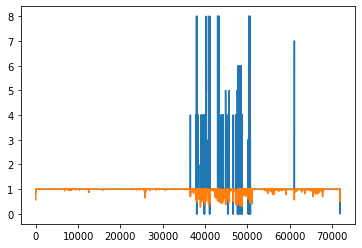

In [ ]:
df, df_p = apply_model_and_check_performance("model_7s-1000e-256b-0015L-preening-nosampling", '239_control2_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5', "completely_labelled_239_control2_gopro_cut_day4.txt")
df['class'].plot()
df['confidence'].plot()
pd.set_option('display.max_rows', df_p.shape[0]+1)
df_p

In [ ]:
base_behaviours = ['eating', 'standing', 'walking', 'eating_flor']

In [ ]:
def expected_anomaly(row):
    return not all(elem in base_behaviours for elem in row['expected'])
        
df_p['expected_anomaly'] = df_p.apply(expected_anomaly, axis=1)

In [ ]:
tp = len(df_p[df_p['expected_anomaly']])
fp = len(df_p[~df_p['expected_anomaly']])
precision = tp / (tp + fp)

In [ ]:
print("These valuese don't consider sample sizes, so they acutally make no sense as is")
print(tp)
print(fp)
print(precision)

These valuese don't consider sample sizes, so they acutally make no sense as is
30
74
0.28846153846153844
